# This is a place to test post-processing blocks. Not to run fem solver multiple times

In [1]:
import blocks as bl
import elementDefs as ed
import constants as cst
import copy
import numpy.typing as nt
import typing as ty
import numpy as np
import scipy.sparse as ss
import scipy.sparse.linalg as ssl
import scipy.optimize as opt
import loads as ls
import typing as ty
import functools as ftl

In [2]:
import pyfe3d as pf3
import pyfe3d.shellprop_utils as psp
import pyfe3Dgcl as p3g

In [3]:
'''Standard test setup'''
data = cst.CAD_DATA
lgl_infs = [4, 4.5, 5, 6] #preparing the k infinity values
csts = copy.deepcopy(cst.CONSTS) #not to touch the actual constants dict
load_case = cst.LOAD_C[2]#landing load case used in the sensitivity study
load_case["FT"] = 0 #landing at full thrust - a weird load case that tests everything at once
eleDict = ed.eledict(csts, cst.INITIAL, cst.CODES)
meshOut = bl.mesh_block(data, cst.INITIAL, eleDict, csts, cst.CODES)

In [4]:
'''Solution cell - run at your own risk XD'''
sol = bl.fem_linear_block(csts, meshOut, load_case, True, True)

4256431.652684309 4205661.95454773  error: -0.011927760687654998


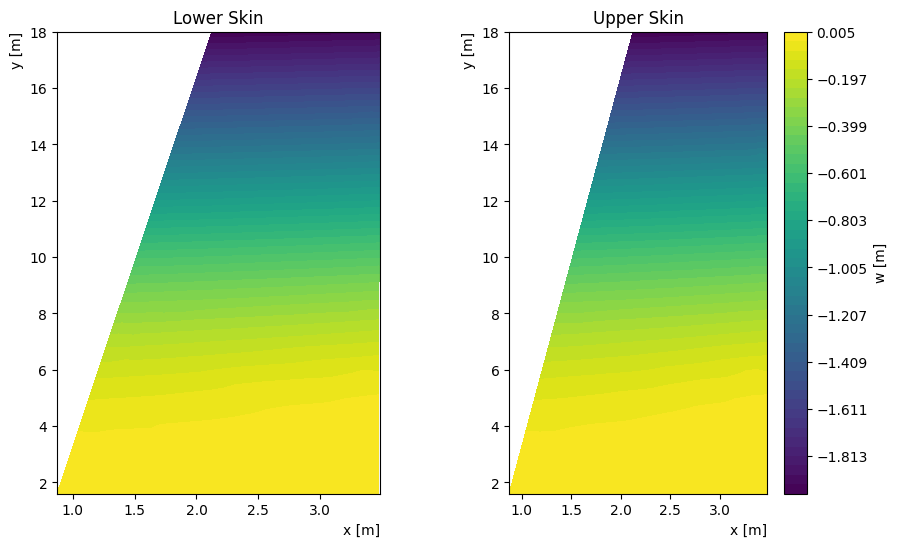

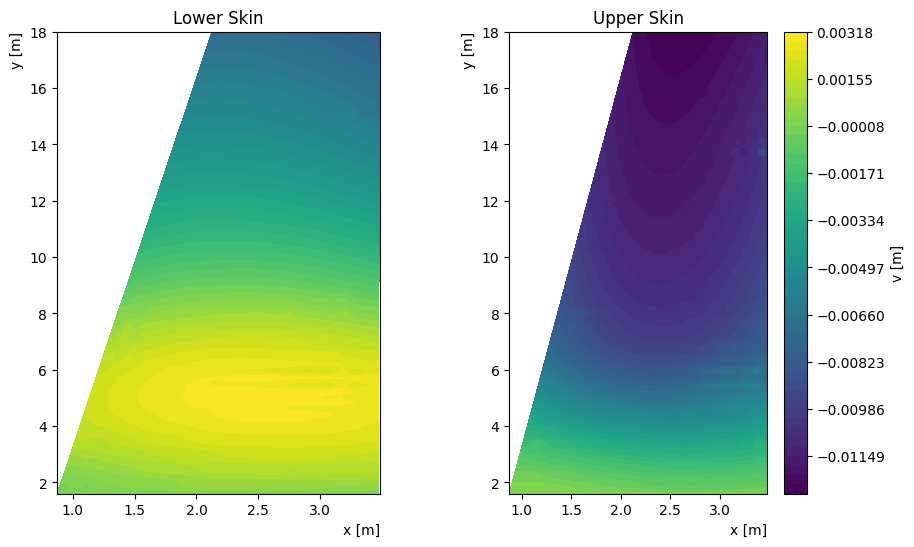

In [5]:
'''Standard deflection plots to check the solution's quality'''
wfig = bl.plot_block(sol['w'], "w", meshOut, csts)
vfig = bl.plot_block(sol['v'], "v", meshOut, csts)

## Ill-conditioning, son

432737.26835456636
-1384369.8747673053


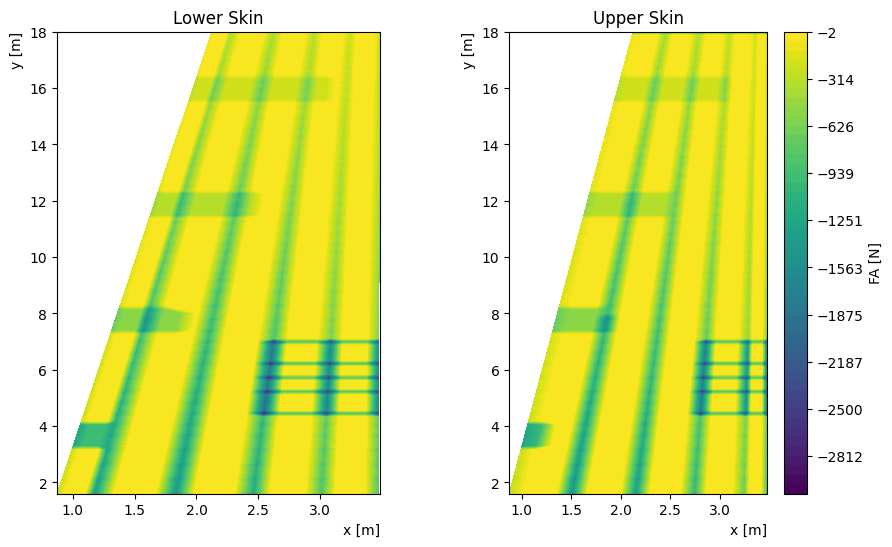

In [6]:
bl.plot_block(sol["weight"][2::pf3.DOF], "FA", meshOut, cst.CONSTS, "N")
print(sol["Fext"][2::pf3.DOF].sum())
print(sol["weight"].sum())

In [8]:
import pyvista as pv
#nodes is our ncoords
elements = meshOut["elements"]
nid_pos = meshOut["nid_pos"]

'''handling each element separately at each elemnt type gets a diff colour'''
#quads
edges_q = list()
for s in elements["quad"]:
    edges_q.append([nid_pos[s.n1], nid_pos[s.n2]])
    edges_q.append([nid_pos[s.n2], nid_pos[s.n3]])
    edges_q.append([nid_pos[s.n3], nid_pos[s.n4]])
    edges_q.append([nid_pos[s.n4], nid_pos[s.n1]])
colors_q = [3]*len(edges_q)

#beams
edges_b = list()
for s in elements["beam"]:
    edges_b.append([nid_pos[s.n1], nid_pos[s.n2]])
colors_b = [2]*len(edges_b)


edges = np.array(edges_b+edges_q)
colors = np.array(colors_b+colors_q)

# We must "pad" the edges to indicate to vtk how many points per edge
padding = np.empty(edges.shape[0], int) * 2
padding[:] = 2
edges_w_padding = np.vstack((padding, edges.T)).T

displs = np.vstack([sol["u"][0::pf3.DOF]+sol["u"][1::pf3.DOF]+sol["u"][2::pf3.DOF]]).T
mesh_ = pv.PolyData(meshOut["ncoords"]+displs, edges_w_padding)

mesh_.plot(
    scalars=colors,
    render_lines_as_tubes=True,
    style='wireframe',
    line_width=1,
    cmap='jet',
    show_scalar_bar=False,
    background='w',
)

Widget(value='<iframe src="http://localhost:62279/index.html?ui=P_0x28326838dd0_1&reconnect=auto" class="pyvis…

In [ ]:
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

def colour_scale(val:float):
    log = np.log10(val) if val>0 else 0
    if log < 2:
        color = 'purple'
    elif log < 4:
        color = 'blue'
    elif log <6:
        color = 'cyan'
    elif log <8:
        color = 'yellow'
    elif log <10:
        color = 'orange'
    else:
        color = 'red'
    return color

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    mcsr = m.tocsr()
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    for row, col in zip(m.row, m.col):
        ax.plot(row, col, 's', colour_scale(mcsr[row, col]), ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

plot_coo_matrix(meshOut["M"])

In [7]:
'''CONDITION NUMBER CHECK'''
def condition_check(A):
    ew1, ev1 = ssl.eigs(A, which='LM')
    print(f"lagest eig:{ew1}")
    print("SM starts")
    ew2, ev2 = ssl.eigs(A, sigma=1e9, which="LM")   #<--- takes a long time
    print(f"smallest eig:{ew1}")

    ew1 = abs(ew1)
    ew2 = abs(ew2)

    condA = ew1.max()/ew2.min()

    #PLOTTING EIGEN VECTORS
    # bl.plot_block(ev1[0::pf3.DOF, 0], "evBIGx1", meshOut, cst.CONSTS)
    # bl.plot_block(ev1[2::pf3.DOF, 1], "evBIGx2", meshOut, cst.CONSTS)
    # bl.plot_block(ev2[0::pf3.DOF, 0], "evSMALLx1", meshOut, cst.CONSTS)
    # bl.plot_block(ev2[2::pf3.DOF, 1], "evSMALLx2", meshOut, cst.CONSTS)

    return condA

print(f"condition num of Kuu-KAuu: {condition_check(sol["KC0uu"]-sol["KAuu"])}")
print(f"condition num of M: {condition_check(meshOut["M"])}")

lagest eig:[5.84434912e+13+0.j 5.84492149e+13+0.j 1.52256600e+13+0.j
 1.52272113e+13+0.j 9.60516575e+12+0.j 9.60579800e+12+0.j]
SM starts
smallest eig:[5.84434912e+13+0.j 5.84492149e+13+0.j 1.52256600e+13+0.j
 1.52272113e+13+0.j 9.60516575e+12+0.j 9.60579800e+12+0.j]
condition num of Kuu-KAuu: 58465.541651557956
lagest eig:[2877.40787901+0.j 2877.14886017+0.j  756.78687031+0.j  756.68254915+0.j
  470.69156524+0.j  470.67475517+0.j]
SM starts
smallest eig:[2877.40787901+0.j 2877.14886017+0.j  756.78687031+0.j  756.68254915+0.j
  470.69156524+0.j  470.67475517+0.j]
condition num of M: 6.113367762933242


# Post processor - attempt 2

In [9]:
def update_after_displacement(meshOut:ty.Dict[str, object], sol:ty.Dict[str, object]):
    "Returns the KG matrix and internal force vector after the displacements from the solver are applied"
    KC0, M, N, x, y, z, mesh, up, ids, pts, nid_pos, ncoords = tuple(meshOut[k] for k in ['KC0', 'M', 'N', 'x', 'y', 'z', 'mesh', 'up', 'ids', 'pts', 'nid_pos', 'ncoords'])
    eleDict, KGv, KGr, KGc, ncoords_flatten = tuple(meshOut[k] for k in ['elements', 'KGv', 'KGr', 'KGc', 'ncoords_flatten'])
    fi = np.zeros(meshOut["N"])
    u, bu, bk, Kuu = tuple(sol[k] for k in ["u", "bu", "bk", "KC0uu"])


    for quad in eleDict["quad"]:
        # NOTE update affects the Quad4RProbe class attribute ue
        quad.update_probe_ue(u)
        quad.update_probe_xe(ncoords_flatten)
        quad.update_KG(KGr, KGc, KGv, quad.shellprop)
        quad.update_probe_finte(quad.shellprop)
        quad.update_fint(fi, quad.shellprop)
    
    for beam in eleDict["beam"]:
        beam.update_probe_ue(u)
        beam.update_probe_xe(ncoords_flatten)
        beam.update_KG(KGr, KGc, KGv, beam.beamprop, 0) #here only values change
        beam.update_probe_finte(beam.beamprop)
        beam.update_fint(fi, beam.beamprop)

    KG = ss.coo_matrix((KGv, (KGr, KGc)), shape=(N, N)).tocsc()
    KGuu = KG[bu, :][:, bu]

    return fi, KGuu, KG
    


In [ ]:
fi, KGuu, KG = update_after_displacement(meshOut, sol)
#NOTE: te very high values in fi are the reaction forces
bl.plot_block(fi[0::pf3.DOF], "Fi_x", meshOut, cst.CONSTS, "N")
bl.plot_block(fi[1::pf3.DOF], "Fi_y", meshOut, cst.CONSTS, "N")
bl.plot_block(fi[2::pf3.DOF], "Fi_z", meshOut, cst.CONSTS, "N")
bl.plot_block(fi[3::pf3.DOF], "Mi_x", meshOut, cst.CONSTS, "N")
bl.plot_block(fi[4::pf3.DOF], "Mi_y", meshOut, cst.CONSTS, "N")
bl.plot_block(fi[5::pf3.DOF], "Mi_z", meshOut, cst.CONSTS, "N")

## Eigen Analysis

lagest eig:[-2.68237256e+10+0.j -7.02336417e+09+0.j  6.85619017e+09+0.j
  4.70968467e+09+0.j  2.54805348e+09+0.j -2.16437015e+09+0.j]
SM starts
smallest eig:[-2.68237256e+10+0.j -7.02336417e+09+0.j  6.85619017e+09+0.j
  4.70968467e+09+0.j  2.54805348e+09+0.j -2.16437015e+09+0.j]
condition num of KGuu: 54.082091944788715


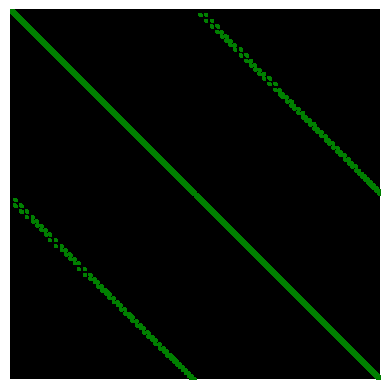

In [11]:
'''Visualise the KG matrix'''
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    ax.plot(m.col, m.row, 's', color='green', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

plot_coo_matrix(KGuu)

'''CONDITION NUMBER CHECK'''
def condition_check(A):
    ew1, ev1 = ssl.eigs(A, which='LM')
    print(f"lagest eig:{ew1}")
    print("SM starts")
    ew2, ev2 = ssl.eigs(A, sigma=1e9, which="LM")   #<--- takes a long time
    print(f"smallest eig:{ew1}")

    ew1 = abs(ew1)
    ew2 = abs(ew2)

    condA = ew1.max()/ew2.min()

    #PLOTTING EIGEN VECTORS
    # bl.plot_block(ev1[0::pf3.DOF, 0], "evBIGx1", meshOut, cst.CONSTS)
    # bl.plot_block(ev1[2::pf3.DOF, 1], "evBIGx2", meshOut, cst.CONSTS)
    # bl.plot_block(ev2[0::pf3.DOF, 0], "evSMALLx1", meshOut, cst.CONSTS)
    # bl.plot_block(ev2[2::pf3.DOF, 1], "evSMALLx2", meshOut, cst.CONSTS)

    return condA

print(f"condition num of KGuu: {condition_check(KGuu)}")

In [12]:
def buckling(sol:ty.Dict[str, object], meshOut:ty.Dict[str, object], KGuu:nt.NDArray[np.float64]):
    K_KAuu = sol["KC0uu"]-sol["KAuu"]
    n_modes = 10 #NOTE: we only care about the load multiplier being smaller/greater than 1, but leave the k higher for accuracy
    eigenvects = np.zeros((meshOut["N"], n_modes), dtype=np.complex128)
    initial = 1
    done = False

    '''step 1) searching for the order of magnitude range'''
    ew, ev = ssl.eigs(A=K_KAuu, M=KGuu, k=n_modes, which="LM", sigma=initial)
    nim = np.count_nonzero(np.imag(ew))
    if nim==len(ew): #All results are non-real
        ew1 = ew
        ev1 = ev #placeholder values needed not to return a purely imaginary vector
        while nim==len(ew1):
            prev_initial = initial
            initial*=10
            ew1, ev1 = ssl.eigs(A=K_KAuu, M=KGuu, k=n_modes, which="LM", sigma=initial)
            nim = np.count_nonzero(np.imag(ew1))
            print(f"nim: {nim}")
        ew = ew1 #we only update eigpairs if we know there are any real ones in the range
        ev = ev1
        lower_bound = prev_initial
        upper_bound = initial #since we are ascending
    else: #not all results are nonreal
        while nim<len(ew):
            prev_initial = initial
            initial/=10
            ew1, ev1 = ssl.eigs(A=K_KAuu, M=KGuu, k=n_modes, which="LM", sigma=initial)
            nim = np.count_nonzero(np.imag(ew1)) #again not to leave afully complex output
            print(f"nim: {nim}")
        lower_bound = initial
        upper_bound = prev_initial #since we are descending
    

    '''step 2) if we found our region'''
    for i in range(5): #three iterations should be enough for convergence
        print(f"lb: {lower_bound}, ub: {upper_bound}, nim: {nim}")
        sgm = (lower_bound+upper_bound)/2
        ew1, ev1 = ssl.eigs(A=K_KAuu, M=KGuu, k=n_modes, which="LM", sigma=sgm)
        nim = np.count_nonzero(np.imag(ew1))
        if nim==len(ew1): #We landed in a fully complex region
            lower_bound = sgm
        else: #we are in the complex region, we can go up
            upper_bound = sgm
            ew = ew1 #we only update eigpairs if we know there are any real ones in the range
            ev = ev1

    eigenvects[sol["bu"], :] = ev

    #reformatting the result as load multiplier, eigenvalues and an array of eigenvectors
    return min(ew[np.isclose(np.imag(ew), 0)]), ew, eigenvects.T

nim: 6
nim: 10
lb: 0.01, ub: 0.1, nim: 10
lb: 0.055, ub: 0.1, nim: 10
lb: 0.055, ub: 0.0775, nim: 3
lb: 0.055, ub: 0.06625, nim: 8
lb: 0.055, ub: 0.060625, nim: 8
buckling load multiplier: (0.059654157762973066+0j)
eigenvalues for buckling: [0.05965416+0.j         0.06270511+0.j         0.06156533-0.00155725j
 0.06156533+0.00155725j 0.06131752-0.00204305j 0.06131752+0.00204305j
 0.06113607-0.00230167j 0.06113607+0.00230167j 0.05912616-0.00174735j
 0.05912616+0.00174735j]


c:\Users\marri\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\contour.py:1568: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
c:\Users\marri\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\contour.py:1569: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
c:\Users\marri\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\contour.py:1234: ComplexWarning: Casting complex values to real discards the imaginary part
  self.levels = np.asarray(levels_arg, np.float64)
c:\Users\marri\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


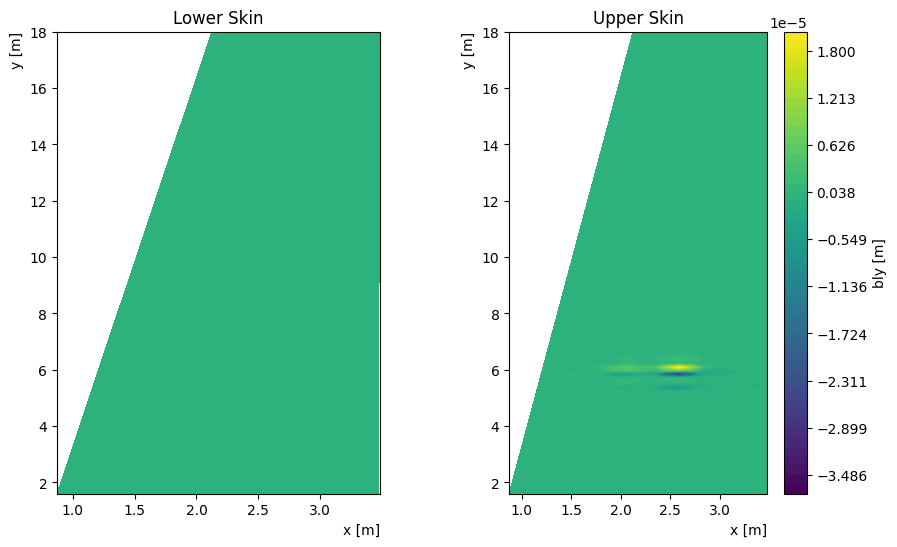

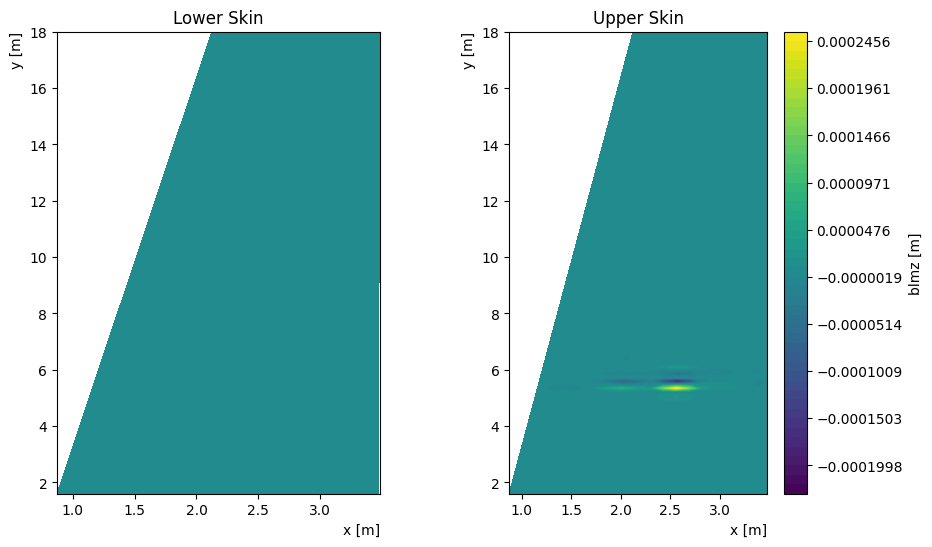

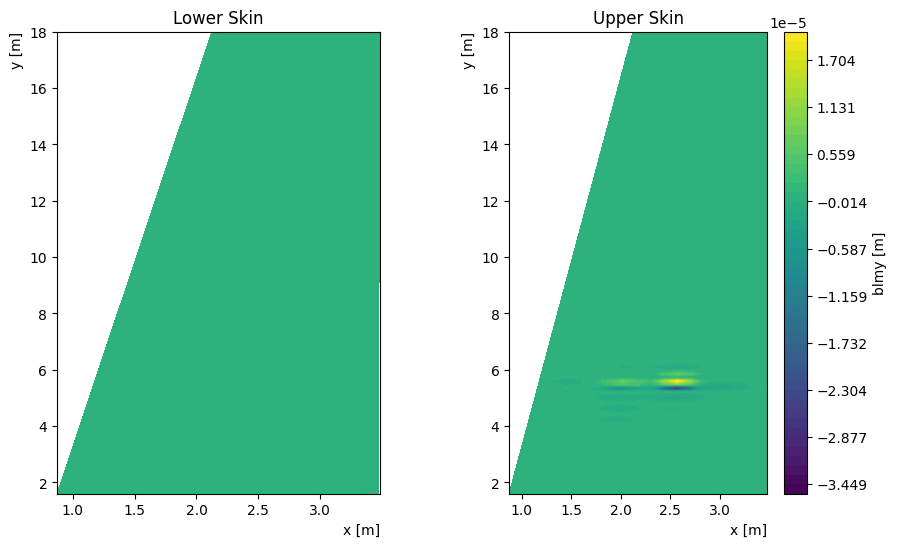

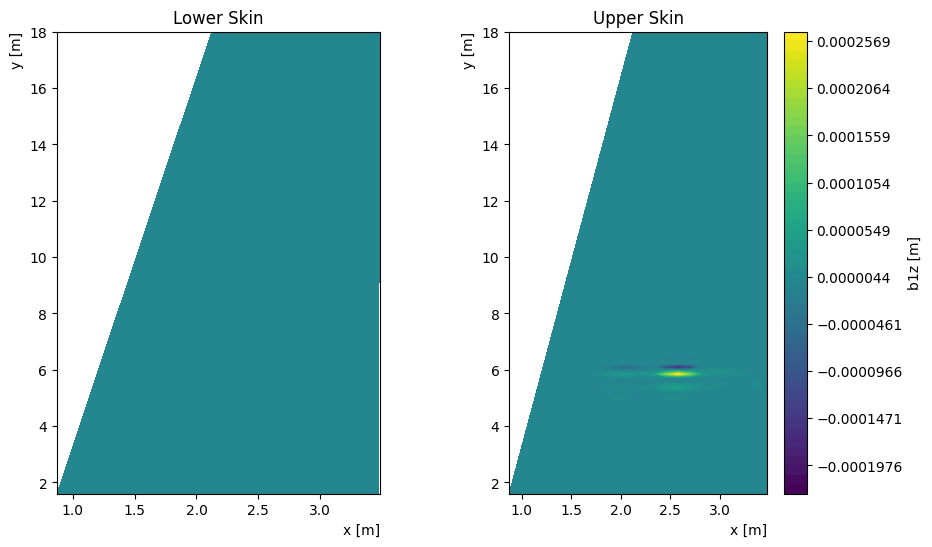

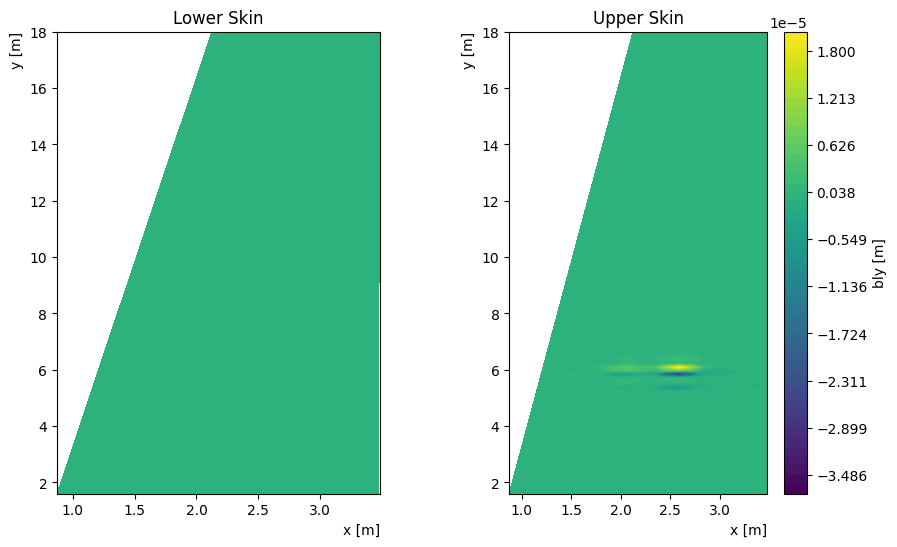

In [13]:
load_mult, ew, ev = buckling(sol, meshOut, KGuu)
print(f"buckling load multiplier: {load_mult}")
print(f"eigenvalues for buckling: {ew}")
bl.plot_block(ev[0, 2::pf3.DOF], "blmz", meshOut, cst.CONSTS, "m")
bl.plot_block(ev[0, 1::pf3.DOF], "blmy", meshOut, cst.CONSTS, "m")
bl.plot_block(ev[1, 2::pf3.DOF], "b1z", meshOut, cst.CONSTS, "m")
bl.plot_block(ev[1, 1::pf3.DOF], "bly", meshOut, cst.CONSTS, "m")

In [14]:
def natfreq(sol:ty.Dict[str, object], meshOut:ty.Dict[str, object]):
    K_KAuu = sol["KC0uu"]-sol["KAuu"]
    Muu = meshOut["M"][sol["bu"], :][:, sol["bu"]]
    n_modes=7#TODO: How many to use
    eigenvects = np.zeros((meshOut["N"], n_modes), dtype=np.complex128)

    ew, ev = ssl.eigs(A=K_KAuu, M=KGuu, k=n_modes, which="LM", sigma=-1.) #TODO: copy pasted. verify it still holds
    eigenvects[sol["bu"], :] = ev

    #reformatting the result as omega_ns and an array of eigenvectors
    return ew**.5, eigenvects.T


natural frequencies: [8.04096038e-05+0.99984956j 8.04096038e-05-0.99984956j
 1.04715425e-04+0.99986247j 1.04715425e-04-0.99986247j
 1.70605829e-04+1.00005646j 1.70605829e-04-1.00005646j
 1.85744890e-04+1.00000497j]


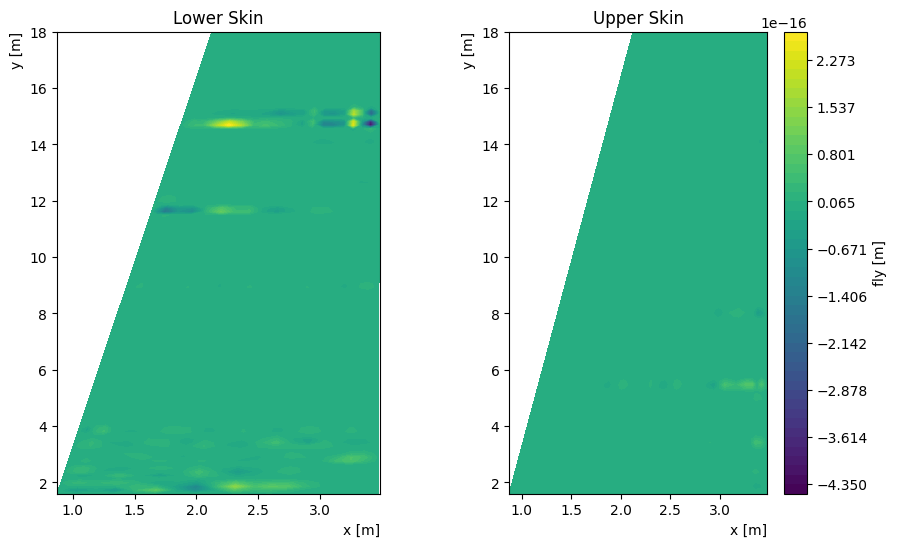

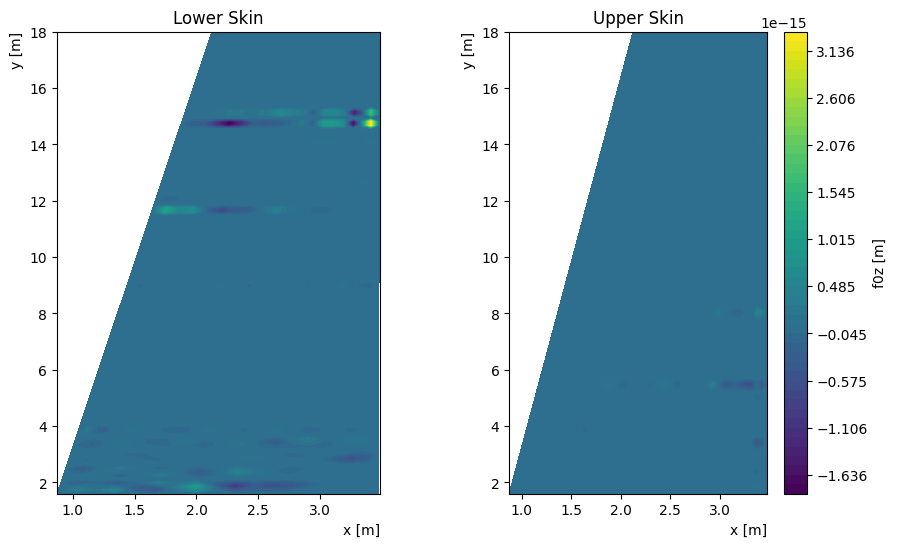

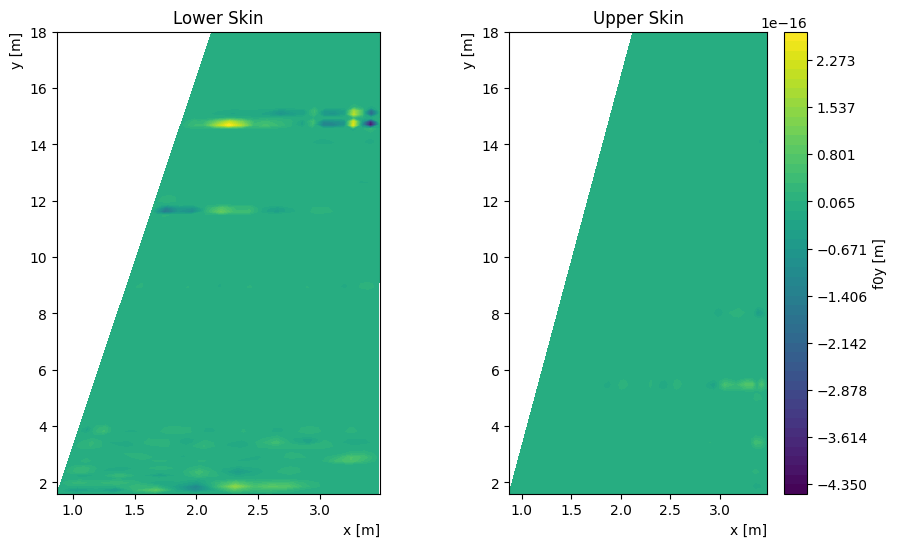

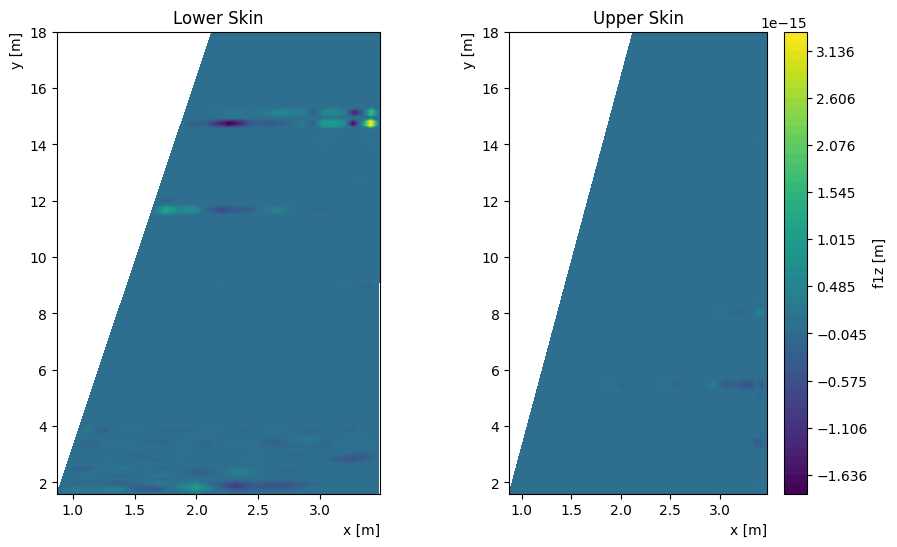

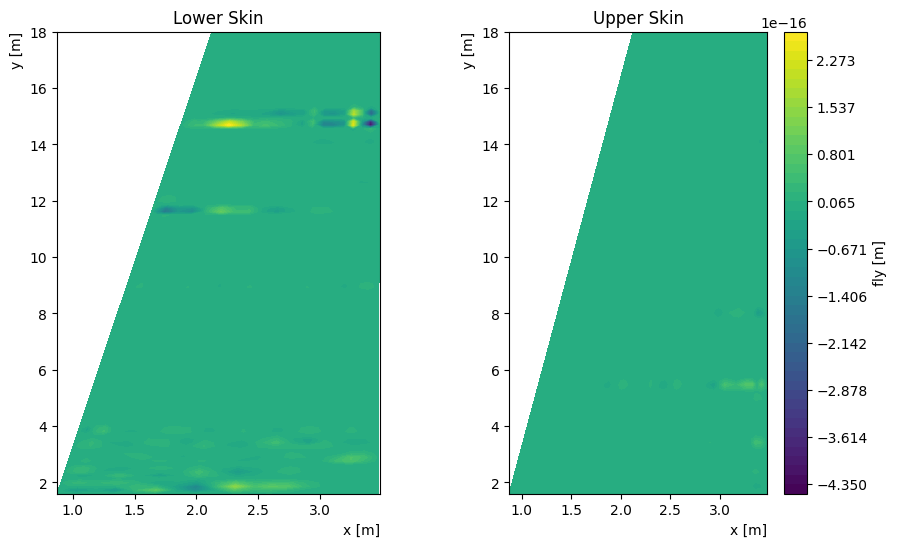

In [14]:
omega_n, omega_v = natfreq(sol, meshOut)

print(f"natural frequencies: {omega_n}")
bl.plot_block(omega_v[0, 2::pf3.DOF], "f0z", meshOut, cst.CONSTS, "m")
bl.plot_block(omega_v[0, 1::pf3.DOF], "f0y", meshOut, cst.CONSTS, "m")
bl.plot_block(omega_v[1, 2::pf3.DOF], "f1z", meshOut, cst.CONSTS, "m")
bl.plot_block(omega_v[1, 1::pf3.DOF], "fly", meshOut, cst.CONSTS, "m")

## Stress Analysis

In [16]:
class BeamPlotData():
    def __init__(self, node1, node2, tau, buckl, sgm):
        self.node1 = node1
        self.node2 = node2
        self.sgm = sgm
        self.tau = tau
        self.buc = buckl

def beam_stresses(sizerVars:ty.Dict[str, object], meshOut:ty.Dict[str, object], targetStressDict:ty.Dict[str, ty.Dict[str, object]],
                  codes:ty.Dict[str, str], csts:ty.Dict[str, object])->ty.List[BeamPlotData]:
    '''
    targetStressDict has a format of {eleid:{"sgm":<max normal stress margin>, "buc":<bucklin margin>, "tau":<max shear stress margin>}}
    '''
    beams2plot = list()
    for beam in meshOut["elements"]["beam"]: #at this tage the beam finte will have already been updated
        "0) interpreting the internal forces"
        Nxe1, Vye1, Vze1, Txe1, Mye1, Mze1, Nxe2, Vye2, Vze2, Txe2, Mye2, Mze2 = beam.probe.finte
        assert np.isclose(Nxe1, -Nxe2)
        assert np.isclose(Txe1, -Txe2)
        assert np.isclose(Vye1, -Vye2)
        assert np.isclose(Vze1, -Vze2)
        #from basic equilibrium
        Nxe = Nxe2 #due to sign convention
        Vye = Vye2
        Vze = Vze2
        Txe = Txe2

        "1) division between rails and tubes - different Q"
        if beam.eleid == codes["rail"]: #rails - full circular cross section
            Q = csts["DIN"]**3/12
            rout = csts["DIN"]/2
            w = csts["DIN"]
            sigmay = csts["SIGMAY_STEEL"]
            tauy = csts["TAUY_STEEL"]
        else: #tube elements
            rout = csts["TRUSS_R"]
            code2var = {
                codes["LETE"]:"fLETE",
                codes["spar"]:"fspar",
                codes["rib"]:"frib",
                codes["lg"]:"flg"
            }
            fti = sizerVars[code2var[beam.eleid]]
            Q = 2*rout**3*fti
            w = fti*rout*2 #width for shear - we have 2 thicknesses for tubes
            sigmay = csts["SIGMAY_ALU"]
            tauy = csts["TAUY_ALU"]
        
        "2) For circulars there exists an analytical solution of the optimisation for max stress, requires this moment interpretation:"
        #for bending moments we have to consider 3 locations: edges and extremum of Mz**2+My**2
        Mye = lambda eta: (Mye2+Mye1)*eta-Mye1
        Mze = lambda eta: (Mze2+Mze1)*eta-Mze1
        denominator = (Mye2+Mye1)**2+(Mze2+Mze1)**2 #we need to manually filter out 0 or cancelling moments
        if denominator:
            etas = np.array([0, (Mye1*(Mye2+Mye1)+Mze1*(Mze2+Mze1))/(denominator), 1])
        else:
            etas = np.array([0,1])
        moments_pythagoras = max(np.sqrt(Mye(etas)**2+Mze(etas)**2))

        "3) Obtining the ther necessary parameters"
        J = beam.beamprop.J
        A = beam.beamprop.A
        assert np.isclose(beam.beamprop.Iyy, beam.beamprop.Izz) #we have a tube moments of inertia same, use whichever
        I = beam.beamprop.Iyy
        E = beam.beamprop.E
        L = beam.length

        "4) Stress formulae from sept 20 page"
        tau_max = abs(Txe)*rout/J+np.sqrt(Vye**2+Vze**2)*Q/I/w #strictly positive
        sigma_min = -rout/I*moments_pythagoras+Nxe/A
        sigma_max = rout/I*moments_pythagoras+Nxe/A
        #Euler-Jhonson buckling, using sigma_y for Jhonson parabola to capture issues with operating close to yield strength
        k=.5 #we use only fixed joints (for now)
        if k*L*np.sqrt(A/I) > np.sqrt(2*np.pi**2*E/sigmay): #critical slenderness ratio check
            sigma_cr = np.pi**2*E*I/k**2/L**2/A #euler buckling
        else:
            sigma_cr = sigmay*(1-sigmay*k**2*L**2*A/I/4/np.pi**2/E) #jhonson's parabola

        "5) obtaining failure stress ratios"
        r_b = -sigma_min/sigma_cr #this way tension will display as  further from fail
        r_t = tau_max/tauy
        r_s = max(abs(sigma_min), abs(sigma_max))/sigmay

        "6) most constraining value updates"
        if r_t>targetStressDict[beam.eleid]["tau"]:
            targetStressDict[beam.eleid]["tau"] = r_t
        if r_b>targetStressDict[beam.eleid]["buc"]:
            targetStressDict[beam.eleid]["buc"] = r_b
        if r_s>targetStressDict[beam.eleid]["sgm"]:
            targetStressDict[beam.eleid]["sgm"] = r_s
        
        "7) Saving the beam to be plotted"
        node1 = meshOut["nid_pos"][beam.n1]
        node2 = meshOut["nid_pos"][beam.n2]
        beams2plot.append(BeamPlotData(node1, node2, r_t, r_b, r_s))
    return beams2plot

In [17]:
tsd = {cst.CODES["rail"]:{"buc":0, "tau":0, "sgm":0}, cst.CODES["LETE"]:{"buc":0, "tau":0, "sgm":0}, 
       cst.CODES["lg"]:{"buc":0, "tau":0, "sgm":0}, cst.CODES["rib"]:{"buc":0, "tau":0, "sgm":0}, cst.CODES["spar"]:{"buc":0, "tau":0, "sgm":0},}

beams2plot = beam_stresses(cst.INITIAL, meshOut, tsd, cst.CODES, cst.CONSTS)
print(tsd)

{'rl': {'buc': 1.3202552363757258, 'tau': 0.47977868997137996, 'sgm': 1.2261406821152052}, 'lt': {'buc': 1.4131485332677065, 'tau': 0.5948640315015695, 'sgm': 1.411638533916092}, 'lg': {'buc': 0.9579835020257239, 'tau': 0.6230649382384481, 'sgm': 1.004691888956895}, 'rb': {'buc': 1.2038336481326912, 'tau': 1.7734196457958238, 'sgm': 1.268095898441065}, 'sp': {'buc': 0.4758643251707115, 'tau': 0.1203253784060935, 'sgm': 0.4623553088584481}}


In [18]:
def rotate_2_global(ele, xe, ye, ze):
    xg = ele.r11*xe+ele.r12*ye+ele.r13*ze
    yg = ele.r21*xe+ele.r22*ye+ele.r23*ze
    zg = ele.r31*xe+ele.r32*ye+ele.r33*ze
    return xg, yg, zg

def mohr(sx, sy, txy):
    sigma_avg = (sx+sy)/2
    tau_max = np.sqrt((sx-sy)**2/4+txy**2) #max_shear_strength
    sigma_min = tau_max - sigma_avg
    sigma_max = tau_max + sigma_avg
    return sigma_min, sigma_max, tau_max

def mohr_and_stress_ratios(sx, sy, txy, tz, s_yield, t_yield):
    sigma_min, sigma_max, tau_max = mohr(sx, sy, txy)
    tau_ratio = np.sqrt(tz**2+tau_max**2)/t_yield
    sgm_ratio = max(abs(sigma_max), abs(sigma_min))/s_yield
    return sgm_ratio, tau_ratio
    
class CoordFint():
    def __init__(self, coords, finte, ele):
        self.x, self.y, self.z = coords
        Fxe, Fye, Fze, Mxe, Mye, Mze = finte
        self.Fx, self.Fy, self.Fz = rotate_2_global(ele, Fxe, Fye, Fze)
        self.Mx, self.My, self.Mz = rotate_2_global(ele, Mxe, Mye, Mze)

class QuadPlotData():
    def __init__(self, node_indices, sig, tau):
        self.nodes = node_indices
        self.sig = sig
        self.tau = tau

def skin_stresses(sizerVars:ty.Dict[str, float], meshOut:ty.Dict[str, float], csts:ty.Dict[str, float]):
    nid_pos, ncoords, elements, up, gclids = (meshOut[k] for k in ["nid_pos", "ncoords", "elements", "up", "ids"])

    sigma_max_ratio = 0
    tau_max_ratio = 0
    quads2plot:ty.List[QuadPlotData] = list()
    for quad in elements["quad"]:
        '''
        ASSUMPTIONS FOR LOAD INTERPRETATION:
        - we are inside a beam. thus forces in y are normal forces, forcez in x and z are shear forces.
        This is almost the case except forces that get balanced at their own x or z, but for skin quads that is a minority
        - the wing does not bend in z along x. Mz is affecting stress distr in the normal direction
        - there might be local bending in both x and y. Thus sigma_x != 0 and we still need to apply the mohr circle
        - upon applying mohr we will have 1 sigma value and two taus, we pythagoras the two taus
        - we do not perform any crippling analysis, would be meaningless under such a non-uniform stress distribution.
        The skin will have to be analysed in some more detailed research
        '''
        "0) checking if top or bottom panel - matters for zmaxs and zmins"
        elegclids = [nid_pos[k] for k in (quad.n1, quad.n2, quad.n3, quad.n4)]
        if all(elegclids) in gclids["skinTop"]:
            top=True
        elif all(elegclids) in gclids["skinBot"]:
            top=False
        else:
            raise AssertionError("The skin element does belongs to neither of the skins!!!")

        "0) obtaining internal forces at nodes"
        nodecoords = ncoords[elegclids]
        fintes = [quad.probe.finte[i:i+6] for i in range(4)]
        coordfints = [CoordFint(nco, fie, quad) for nco, fie in zip(nodecoords, fintes)]
        avgCoord = np.average(nodecoords, 0)
        sorted_cfts:ty.Dict[str, CoordFint] = dict()
        for cft in coordfints:
            if cft.x>avgCoord[0] and cft.y>avgCoord[1]: #the +x +y corner
                sorted_cfts["++"] = cft
            elif cft.x>avgCoord[0] and cft.y<avgCoord[1]: #the +x -y corner
                cft.Mz*=-1
                cft.Fy*=-1
                cft.Mx*=-1
                cft.Fx*=-1
                cft.Fz*=-1
                sorted_cfts["+-"] = cft
            elif cft.x<avgCoord[0] and cft.y>avgCoord[1]: #the -x +y corner
                cft.My*=-1
                sorted_cfts["-+"] = cft
            elif cft.x<avgCoord[0] and cft.y<avgCoord[1]: #the -x -y corner
                cft.My*=-1
                cft.Mz*=-1
                cft.Fy*=-1
                cft.Mx*=-1
                cft.Fx*=-1
                cft.Fz*=-1
                sorted_cfts["--"] = cft

        "1) averaging the widths"
        wx = .5*(sorted_cfts["++"].x+sorted_cfts["+-"].x-sorted_cfts["-+"].x-sorted_cfts["--"].x)
        wy = .5*(sorted_cfts["++"].y+sorted_cfts["-+"].y-sorted_cfts["+-"].y-sorted_cfts["--"].y)
        #NOTE: in spite of sweep, dihedral and curvature, we will consider shear forces in x and z and normal in y, as all those angles are small

        "2) interpretting the cross-section"
        nc = wx/sizerVars["csp"] #n of stiffeners in spanwise dir, packed along the chord
        nb = wy/sizerVars["bsp"] #n of stiffeners in chordwise dir, packed along the span
        t = sizerVars["tskin"]
        h = csts["ORTHG_H"]
        Axx = t*(nc*h+wx)
        zbarxx = t*(nc*h*(h+t)+t*wx)/2/Axx #always defined facing inwards - for other section properties only!!!
        Ixx = wx*t**3/12+wx*t*(zbarxx-t/2)**2+nc*h**3*t/12+nc*h*t*((h+t)/2-zbarxx)**2
        Qxx = nc*(h+t-zbarxx)**2/2*t #centroid moment for shear
        wsx = nc*t #shear width for shear in z
        Ayy = t*(nb*h+wy)
        zbaryy = t*(nb*h*(h+t)+t*wy)/2/Ayy #always defined facing inwards - for other section properties only!!!
        Iyy = wy*t**3/12+wy*t*(zbaryy-t/2)**2+nb*h**3*t/12+nb*h*t*((h+t)/2-zbaryy)**2
        #computing the Izz has quadratic contributions from stiffeners, hence we round down the nc to stay conservative
        stiffxs = np.linspace(-wx/2, wx/2, int(nc))
        posesForQzz = stiffxs[-int(int(nc)/2):] #computing Q in the meantime, as it also uses the stiffener spacings
        Qzz = wx/4*wx/2*t+posesForQzz.sum()*h*t
        Izz = t*wx**3/12+h*t*(stiffxs**2).sum() #we do not need Iyy on the spanwsie wall, see assumptions
        wsz = t #width in z for shear in x
        #x and y coords can be seen as +-wx/2 and +-wy/2, respectively, z coords depend of which skin we are looking at:
        if top:
            zmax = -zbarxx
            zmin = -(h+t-zbarxx)
        else:
            zmax = h+t-zbarxx
            zmin = -zbarxx

        "3)stress calculations for every node"
        #the 4 stress ratios of the element being the most constraining stress ratios obtained at each of the 4 nodes
        srs_ele, trs_ele = list(), list() #later averaged
        for cft in sorted_cfts.values():
            "3.1) particular stresses"
            tau_z = abs(cft.Fz)*Qxx/wsx/Ixx
            tau_xy = abs(cft.Fx)*Qzz/wsz/Izz
            sigma_x_zmax = cft.My*zmax/Iyy
            sigma_x_zmin = cft.My*zmin/Iyy
            sigma_y = lambda x, z: cft.Fy/Axx-cft.Mx*z/Ixx+cft.Mz*x/Izz
            sigma_y_zmin_xmin = sigma_y(-wx/2, zmin)
            sigma_y_zmax_xmin = sigma_y(-wx/2, zmax)
            sigma_y_zmin_xmax = sigma_y(wx/2, zmin)
            sigma_y_zmax_xmax = sigma_y(wx/2, zmax)

            "4) possible Mohr circles"
            srs = np.zeros(4)
            trs = np.zeros(4)
            srs[0], trs[0] = mohr_and_stress_ratios(sigma_x_zmin, sigma_y_zmin_xmin, tau_xy, tau_z, csts["SIGMAY_ALU"], csts["TAUY_ALU"])
            srs[1], trs[1] = mohr_and_stress_ratios(sigma_x_zmin, sigma_y_zmin_xmax, tau_xy, tau_z, csts["SIGMAY_ALU"], csts["TAUY_ALU"])
            srs[2], trs[2] = mohr_and_stress_ratios(sigma_x_zmax, sigma_y_zmax_xmin, tau_xy, tau_z, csts["SIGMAY_ALU"], csts["TAUY_ALU"])
            srs[3], trs[3] = mohr_and_stress_ratios(sigma_x_zmax, sigma_y_zmax_xmax, tau_xy, tau_z, csts["SIGMAY_ALU"], csts["TAUY_ALU"])
            srs_ele.append(srs.max())
            trs_ele.append(trs.max())

        "5) obtaining the averaged results, creating a plot element and updating the overall maxima if necessary"
        assert len(srs_ele) == 4
        assert len(trs_ele) == 4
        sr_mean = sum(srs_ele)/4
        tr_mean = sum(trs_ele)/4
        if sr_mean > sigma_max_ratio:
            sigma_max_ratio = sr_mean
        if tr_mean > tau_max_ratio:
            tau_max_ratio = tr_mean
        quads2plot.append(QuadPlotData(elegclids, sr_mean, tr_mean))

    return sigma_max_ratio, tau_max_ratio, quads2plot


In [19]:
sigma_max_ratio, tau_max_ratio, quads2plot = skin_stresses(cst.INITIAL, meshOut, cst.CONSTS)
print(sigma_max_ratio, tau_max_ratio)

332.53241424117 374.6292296905978


### Pyvista

In [20]:
import pyvista
pyvista.set_plot_theme('document')
pyvista.set_jupyter_backend('trame')
pyvista.global_theme.window_size = [600, 400]
pyvista.global_theme.axes.show = True
pyvista.global_theme.anti_aliasing = 'fxaa'
pyvista.global_theme.show_scalar_bar = True

In [23]:
import pyvista as pv

edges = []
bucs = []
taus = []
sgms = []

for bpd in beams2plot:
    edges.append([bpd.node1, bpd.node2])
    bucs.append(bpd.buc)
    taus.append(bpd.tau)
    sgms.append(bpd.sgm)
    
padding = np.empty(len(edges), int) * 2
padding[:] = 2
edges_w_padding = np.vstack((padding, np.array(edges).T)).T
edges_w_padding

meshpv = pv.PolyData(meshOut["ncoords"], edges_w_padding)

line_width = np.ones(len(edges))
meshpv.plot(scalars=sgms,
            render_lines_as_tubes=True,
    style='wireframe',
    line_width=5,
    cmap='jet',
    show_scalar_bar=True,
    background='w',)
print(edges)

Widget(value='<iframe src="http://localhost:62279/index.html?ui=P_0x28393bc9280_4&reconnect=auto" class="pyvis…

[[4, 25], [25, 46], [46, 67], [67, 88], [88, 109], [109, 130], [130, 151], [151, 172], [172, 193], [193, 214], [214, 235], [235, 256], [256, 277], [277, 298], [298, 319], [319, 340], [340, 361], [361, 382], [382, 403], [403, 424], [424, 445], [445, 466], [466, 487], [487, 508], [508, 529], [529, 550], [550, 571], [571, 592], [592, 613], [613, 634], [634, 655], [655, 676], [676, 697], [697, 718], [718, 739], [739, 760], [760, 781], [781, 802], [802, 823], [823, 844], [844, 865], [865, 886], [886, 907], [907, 928], [928, 949], [949, 970], [970, 991], [991, 1012], [1012, 1033], [1033, 1054], [1054, 1075], [1075, 1096], [1096, 1117], [1117, 1138], [1138, 1159], [1159, 1180], [1180, 1201], [1201, 1222], [1222, 1243], [1243, 1264], [1264, 1285], [1285, 1306], [1306, 1327], [1327, 1348], [1348, 1369], [1369, 1390], [1390, 1411], [1411, 1432], [1432, 1453], [1453, 1474], [1474, 1495], [1495, 1516], [1516, 1537], [1537, 1558], [1558, 1579], [1579, 1600], [1600, 1621], [1621, 1642], [1642, 1663]

In [24]:
import pyvista as pv
pl = pv.Plotter()
ncoords, nid_pos, x,y,z = (meshOut[k] for k in ['ncoords', 'nid_pos', 'x', 'y', 'z'])
conns = list()

for quad in quads2plot:
    conns+=[4]+list(quad.nodes)

conns = np.array(conns)
types = [pv.CellType.QUAD]*len(quads2plot)

pl.show_axes()
pl.add_mesh(pv.UnstructuredGrid(conns, types, ncoords), scalars=[min(quad.tau, 100) for quad in quads2plot])
pl.add_scalar_bar()
pl.show()

Widget(value='<iframe src="http://localhost:62279/index.html?ui=P_0x28393c72ff0_5&reconnect=auto" class="pyvis…

# Post Processor - internal forces and margins for every failure mode

In [6]:
def flutter_block(consts:ty.Dict[str, object], meshOuts:ty.Dict[str, object], lc:ty.Dict[str, object], sol:ty.Dict[str, object]):
    les, tes, up, M, N = [meshOuts[k] for k in ["les", "tes", "up", "M", "N"]]
    foils, bres, cres, velocities, airfs = [consts[k] for k in ["FOILS", "BRES", "CRES", "VELOCITIES", "FOILS"]]
    op, nlg = [lc[k] for k in ["op", "nlg"]]
    ncoords_s, ids_s, bu, Kuu = [sol[k] for k in ["ncoords_s", "ids_s", "bu", "KC0uu"]]
    airplane, vlm, forces, moments = ls.vlm(les, tes, airfs, op, bres, cres, np.zeros(len(airfs)))
    W, Fext = ls.aero2fem(vlm, ncoords_s, ids_s, N, pf3.DOF)
    W_u_to_p = ls.fem2aero(les, np.zeros(len(foils)), ncoords_s, ids_s, N, pf3.DOF)

    #natural freqs for flutter
    return ls.flutter_omegans(velocities, M, bu, W_u_to_p, Kuu, W, les, tes, airfs, op, up.fft.y, bres, cres)


In [6]:
def rotate_2_local(ele, id_node, ncoords):
    xg, yg, zg = ncoords[id_node]
    xe = ele.r11*xg+ele.r21*yg+ele.r31*zg
    ye = ele.r12*xg+ele.r22*yg+ele.r32*zg
    ze = ele.r13*xg+ele.r23*yg+ele.r33*zg
    return xe, ye, ze

def quad_plate_stress(ele, finte_part, wxe, wye):
    Fxe, Fye, Fze, Mxe, Mye, Mze = np.asanyarray(finte_part)

    #plane stresses
    sx = Fxe/wye/ele.shellprop.h
    sy = Fye/wxe/ele.shellprop.h
    sxC = sx-abs(Mye/(wye*ele.shellprop.h**2/12)/2)
    sxT = sx+abs(Mye/(wye*ele.shellprop.h**2/12)/2)
    syC = sy-abs(Mxe/(wxe*ele.shellprop.h**2/12)/2)
    syT = sy+abs(Mxe/(wxe*ele.shellprop.h**2/12)/2)

    #out-of-plane stresses TODO verify
    tz = np.abs(Fze)/min(wye, wxe)/ele.shellprop.h #we make the worse wall assumption, that the shear flows in a different direction than we might want it to 
    #for now, we assume no modification due to Mze TODO add that
    return np.array([sxC, sxT, syC, syT, tz, sx, sy]) #we keep sx, sy for future mohr circle caluclations


'''COPYPASTE THIS TO blocks.py ONCE DONE!!!'''
def stress_block(defl:ty.Dict[str, nt.NDArray[np.float64]], meshOuts:ty.Dict[str,object], 
                         codes:ty.Dict[str,str], sizerVals:ty.Dict[str,str], consts:ty.Dict[str,object], debug=False):
    rfl, din = tuple(consts[k] for k in ['RIB_FLANGE', 'DIN'])
    tsp, tsk, trb, tpl = tuple(sizerVals[k] for k in ['tspar', 'tskin', 'trib', 'tpan'])
    KC0, M, N, x, y, z, mesh, up, ids, pts, nid_pos, ncoords = tuple(meshOuts[k] for k in ['KC0', 'M', 'N', 'x', 'y', 'z', 'mesh', 'up', 'ids', 'pts', 'nid_pos', 'ncoords'])
    eleDict, KGv, KGr, KGc, ncoords_flatten = tuple(meshOuts[k] for k in ['elements', 'KGv', 'KGr', 'KGc', 'ncoords_flatten'])
    fi = np.zeros(meshOuts["N"])
    u, bu, bk, Kuu = tuple(defl[k] for k in ["u", "bu", "bk", "KC0uu"])

    '''INTERNAL LOADS'''
    #only for quads and beams as of now - that's all we are using
    sigma_most = {'quad':{codes["skin"]:[], codes["panelRib"]:[], codes["panelPlate"]:[], codes["spar"]:[]},
                'beam':{codes["rail"]:[], codes["panelFlange"]:[]}}
    tau_most = {'quad':{codes["skin"]:[], codes["panelRib"]:[], codes["panelPlate"]:[], codes["spar"]:[]},
                'beam':{codes["rail"]:[], codes["panelFlange"]:[]}}
    sorted_eles = {'quad':{codes["skin"]:[], codes["panelRib"]:[], codes["panelPlate"]:[], codes["spar"]:[]},
                'beam':{codes["rail"]:[], codes["panelFlange"]:[]}}
    for quad in eleDict["quad"]:
        # NOTE update affects the Quad4RProbe class attribute ue
        quad.update_probe_ue(u)
        quad.update_probe_xe(ncoords_flatten)
        quad.update_KG(KGr, KGc, KGv, quad.shellprop)
        quad.update_probe_finte(quad.shellprop)
        quad.update_fint(fi, quad.shellprop)

        "stresses"
        #transferring nodes into local coord system
        xe1, ye1, ze1 = rotate_2_local(quad, nid_pos[quad.n1], ncoords)
        xe2, ye2, ze2 = rotate_2_local(quad, nid_pos[quad.n2], ncoords)
        xe3, ye3, ze3 = rotate_2_local(quad, nid_pos[quad.n3], ncoords)
        xe4, ye4, ze4 = rotate_2_local(quad, nid_pos[quad.n4], ncoords)

        #getting the widths of the element - we have some very elongated element, so necessary to consider
        #current algorithm is wxe*wye=SA, wxe~max(xes)-min(xes), wyeb similarly
        #area by two cross products
        SA = .5*np.linalg.norm(np.cross([xe4-xe1, ye4-ye1, ze4-ze1], [xe2-xe1, ye2-ye1, ze2-ze1]))+.5*np.linalg.norm(np.cross([xe1-xe2, ye1-ye2, ze1-ze2], [xe3-xe2, ye3-ye2, ze3-ze2]))
        wxeprop=max(xe1, xe2, xe3, xe4)-min(xe1, xe2, xe3, xe4)
        wyeprop=max(ye1, ye2, ye3, ye4)-min(ye1, ye2, ye3, ye4)
        c = np.sqrt(SA/wxeprop/wyeprop)
        wxe = wxeprop*c
        wye = wyeprop*c

        #stress calculation for the four nodes - then averaged
        stresses1 = quad_plate_stress(quad, quad.probe.finte[:6], wxe, wye)
        stresses2 = quad_plate_stress(quad, quad.probe.finte[6:12], wxe, wye)
        stresses3 = quad_plate_stress(quad, quad.probe.finte[12:18], wxe, wye)
        stresses4 = quad_plate_stress(quad, quad.probe.finte[18:], wxe, wye)
        stresses = (stresses1+stresses2+stresses3+stresses4)/4

        #further individual post-processing and saving of the results
        if quad.eleid == codes["skin"]:
            tau_most["quad"][codes["skin"]].append(stresses[4])
            sigma_most["quad"][codes["skin"]].append(max(np.abs(stresses[:4])))
            sorted_eles["quad"][codes["skin"]].append(quad)

        elif quad.eleid == codes["panelRib"]:
            tau_most["quad"][codes["panelRib"]].append(stresses[4])
            sigma_most["quad"][codes["panelRib"]].append(max(np.abs(stresses[:4])))
            sorted_eles["quad"][codes["panelRib"]].append(quad)

        elif quad.eleid == codes["panelPlate"]:
            tau_most["quad"][codes["panelPlate"]].append(stresses[4])
            sigma_most["quad"][codes["panelPlate"]].append(max(np.abs(stresses[:4])))
            sorted_eles["quad"][codes["panelPlate"]].append(quad)

        elif quad.eleid == codes["spar"]:
            tau_most["quad"][codes["spar"]].append(stresses[4])
            sigma_most["quad"][codes["spar"]].append(max(np.abs(stresses[:4])))
            sorted_eles["quad"][codes["spar"]].append(quad)

        else: raise NotImplementedError(f"A quad element of eleid {quad.eleid} not accounted for in post-processing!")

    for beam in eleDict["beam"]:
        beam.update_probe_ue(u)
        beam.update_probe_xe(ncoords_flatten)
        beam.update_KG(KGr, KGc, KGv, beam.beamprop, 0) #here only values change
        beam.update_probe_finte(beam.beamprop)
        beam.update_fint(fi, beam.beamprop) 

        "stresses"
        Fx1, Fy1, Fz1, Mx1, My1, Mz1 = beam.probe.finte[:6]

        A, J, Iyy, Izz = beam.beamprop.A, beam.beamprop.J, beam.beamprop.Iyy, beam.beamprop.Izz 

        if beam.eleid == codes["rail"]:
            #normal stress
            sigma_most["beam"][codes["rail"]].append(abs(Fx1)/A+din/2*np.sqrt((Mz1/Izz)**2+(My1/Iyy)**2))
                                                     
            #shear stress - we have to run a maximalisation problem for every node
            radius_fun = lambda xe:xe[0]**2+xe[1]**2
            rad_constr = opt.NonlinearConstraint(radius_fun, -1e-6, din**2/4) #TODO: add actual jacobian
            #negative to use minimise
            shearsq_fun1 = lambda xe: -(Mx1*xe[1]/J+Fy1/3/Izz*(din**2/4-xe[0]**2))**2-(Mx1*xe[0]/J+Fz1/3/Iyy*(din**2/4-xe[1]**2))**2
            shearsq1 = opt.minimize(shearsq_fun1, np.array([0,0]), constraints=[rad_constr],
                                    method="Cobyla")
            print(shearsq1) if debug else None
            tau_most["beam"][codes["rail"]].append(np.sqrt(-shearsq1.fun)) #back to actual shear stress

            #saving the element in a matching format
            sorted_eles["beam"][codes["rail"]].append(beam)

        elif beam.eleid == codes["panelFlange"]:
            #most constraining normal stress in when bending stresses are in the same direction as axial stress
            #! For isotropic materials only!
            sigma_most["beam"][codes["panelFlange"]].append(abs(Fx1)/A+(abs(My1)/Iyy*trb/2+abs(Mz1)/Izz*rfl/2))

            #most constraining shear stress - either one of the sides with torsion of the middle
            def tau_most_at_node(Mx, Fy, Fz):
                tau_Mx = abs(Mx)*(3+1.8*trb/rfl)/rfl/trb**2 #directions don't matter, we can get all combinations
                tau_Fz = abs(Fz)*trb**2/8/Iyy
                tau_Fy = abs(Fy)*rfl**2/8/Izz
                return max(tau_Mx+tau_Fz, tau_Mx+tau_Fy, np.sqrt(tau_Fy**2+tau_Fz**2))
            tau_most["beam"][codes["panelFlange"]].append(tau_most_at_node(Mx1, Fy1, Fz1))

            #saving the element in a matching format
            sorted_eles["beam"][codes["panelFlange"]].append(beam)

        else: raise NotImplementedError(f"A beam element of eleid {quad.eleid} not accounted for in post-processing!")
          
    fi[bk] = 0 #to avoid internal force at clamps which can be latge and are weirdly defined
    
    return sorted_eles, tau_most, sigma_most, fi

def eigen_analysis_block(defl:ty.Dict[str, nt.NDArray[np.float64]], meshOuts:ty.Dict[str,object], 
                         codes:ty.Dict[str,str], sizerVals:ty.Dict[str,str], consts:ty.Dict[str,object], v0b=None, v0f=None, debug=False):
    rfl, din = tuple(consts[k] for k in ['RIB_FLANGE', 'DIN'])
    tsp, tsk, trb, tpl = tuple(sizerVals[k] for k in ['tspar', 'tskin', 'trib', 'tpan'])
    KC0, M, N, x, y, z, mesh, up, ids, pts = tuple(meshOuts[k] for k in ['KC0', 'M', 'N', 'x', 'y', 'z', 'mesh', 'up', 'ids', 'pts'])
    eleDict, KGv, KGr, KGc, ncoords_flatten = tuple(meshOuts[k] for k in ['elements', 'KGv', 'KGr', 'KGc', 'ncoords_flatten'])
    u, bu, bk, Kuu, KAuu = tuple(defl[k] for k in ["u", "bu", "bk", "KC0uu", "KAuu"])

    if v0b is None:
        v0b = u.copy()
    v0bu = v0b[bu]
    
    if v0f is None:
        v0f = u.copy()
    v0fu = v0f[bu]

    '''BUCKLING ANALYSIS'''
    KG = ss.coo_matrix((KGv, (KGr, KGc)), shape=(N, N)).tocsc()
    KGuu = KG[bu, :][:, bu]
    num_eig_lb = 4 #We only need one, the load multiplier

    eigvecs = np.zeros((N, num_eig_lb))
    print("buckling eigs started") if debug else None
    eigvals, eigvecsu = ssl.eigs(A=KGuu, k=num_eig_lb, which="LR", M=Kuu-KAuu, tol=1e-8, v0=v0bu)
    print("buckling eigs ended") if debug else None
    eigvals = 1./eigvals
    eigvecs[bu] = eigvecsu 
    load_mult = eigvals[0] #TODO from what it seems to me has to be strictly greater than one
    print("buckling interpreted") if debug else None

    '''EIGENFREQUENCY ANALYSIS'''
    Muu = M[bu, :][:, bu]
    num_eig=6 #TODO: how many
    print("flutter eigs started") if debug else None
    eigvalsO, eigvectsOu = ssl.eigs(A=Kuu-KAuu, M=Muu, sigma=-1., which='LM', #eigs so that we see the complex part
            k=num_eig, tol=1e-8, v0=v0fu)
    print("flutter eigs ended") if debug else None
    omegan = eigvalsO**0.5
    eigvectsO = np.zeros(N, dtype=np.complex128)
    eigvectsO[bu] = eigvectsOu[:, 0]
    print("flutter interpreted") if debug else None

    return KG, KGuu, load_mult, eigvecs, eigvals, omegan, eigvectsO, v0b, v0f

'A WRAPPER FUNCTION FOR ALL POST-PROCESSING'    
def post_processor_block(defl:ty.Dict[str, nt.NDArray[np.float64]], meshOuts:ty.Dict[str,object], 
                         codes:ty.Dict[str,str], sizerVals:ty.Dict[str,str], consts:ty.Dict[str,object], v0b=None, v0f=None, debug=False):
    
    sorted_eles, tau_most, sigma_most, fi = stress_block(defl, meshOuts, codes, sizerVals, consts, debug)
    KG, KGuu, load_mult, eigvecs, eigvals, omegan, eigvectsO, v0b, v0f = eigen_analysis_block(defl, meshOuts, codes, sizerVals, consts, v0b, v0f, debug)

    return {"elements":sorted_eles, "fi":fi, "KG":KG, "KGuu":KGuu, "load_mult":load_mult, "eigvecs":eigvecs, "eigvals":eigvals, "omegan":omegan,
            "sigma":sigma_most, "tau":tau_most, "flutter_eigvec":eigvectsO, "v0b":v0b, "v0f":v0f}

## Stress

Here be code just for stress sub-block testing

In [8]:
sorted_eles, tau_most, sigma_most, fi = stress_block(sol, meshOut, cst.CODES, cst.INITIAL, cst.CONSTS)


cond KGuu: 3266889617788044.0, KGv: [ 0.          0.          0.         ...  1.78468926 -0.2835665
  1.76516817], KGC: [    0     1     2 ... 34437 34438 34439], KGR: [    0     0     0 ... 34439 34439 34439]


In [ ]:
for r in sorted_eles["quad"][cst.CODES["panelPlate"]]:
    if not np.isclose(np.asanyarray(r.probe.finte).sum(), 0):
        print(np.asanyarray(r.probe.finte))

[ 1.77964577e+04  1.15888556e+04  6.71504560e+02  9.94250720e+00
  1.10935094e+01  0.00000000e+00 -3.08507112e+03  4.62328238e+03
  8.53595290e+02  1.03638555e+01  1.10750764e+01 -6.13813730e-02
 -8.21098839e+03 -5.92453004e+03 -6.71504560e+02  8.63117406e+00
  1.14945337e+01  2.98372438e-15 -6.50039814e+03 -1.02876080e+04
 -8.53595290e+02  9.10621826e+00  1.14072536e+01  0.00000000e+00]
[ 1.76198454e+04  1.02835008e+04 -6.00194303e+02 -9.15906450e+00
 -7.47265907e-01  0.00000000e+00 -1.03467392e+03  4.14647890e+03
 -6.19227363e+02 -1.07888054e+01 -9.29148632e-01  2.98155597e-15
 -8.89779582e+03 -5.63784017e+03  6.00194303e+02 -4.46946680e+00
 -6.96719466e-01 -6.08129343e-02 -7.68737570e+03 -8.79213954e+03
  6.19227363e+02 -6.00124810e+00 -5.82402898e-01  0.00000000e+00]
[ 2.96490440e+04  1.48613792e+04 -6.23341181e+02 -1.79481468e+01
 -2.04628400e+00  0.00000000e+00  7.47457486e+03  5.57314599e+03
 -6.72601347e+02 -1.77359904e+01 -1.98985380e+00 -6.08129343e-02
 -2.79727676e+04 -1.324

In [ ]:
import pyvista
pyvista.set_plot_theme('document')
pyvista.set_jupyter_backend('trame')
pyvista.global_theme.window_size = [600, 400]
pyvista.global_theme.axes.show = True
pyvista.global_theme.anti_aliasing = 'fxaa'
pyvista.global_theme.show_scalar_bar = True

In [ ]:
print("BEAMS:")
print(f"sigma rail: max: {max(sigma_most["beam"][cst.CODES["rail"]])}, min:{min(sigma_most["beam"][cst.CODES["rail"]])}")
print(f"tau rail: max: {max(tau_most["beam"][cst.CODES["rail"]])}, min:{min(tau_most["beam"][cst.CODES["rail"]])}")
print(f"sigma flange: max: {max(sigma_most["beam"][cst.CODES["panelFlange"]])}, min:{min(sigma_most["beam"][cst.CODES["panelFlange"]])}")
print(f"tau flange: max: {max(tau_most["beam"][cst.CODES["panelFlange"]])}, min:{min(tau_most["beam"][cst.CODES["panelFlange"]])}")
print("\nQUADS:")
print(f"tau rib: max: {max(tau_most["quad"][cst.CODES["panelRib"]])}, min:{min(tau_most["quad"][cst.CODES["panelRib"]])}")
print(f"sigma rib: max: {max(sigma_most["quad"][cst.CODES["panelRib"]])}, min:{min(sigma_most["quad"][cst.CODES["panelRib"]])}")
print(f"tau plate: max: {max(tau_most["quad"][cst.CODES["panelPlate"]])}, min:{min(tau_most["quad"][cst.CODES["panelPlate"]])}")
print(f"sigma plate: max: {max(sigma_most["quad"][cst.CODES["panelPlate"]])}, min:{min(sigma_most["quad"][cst.CODES["panelPlate"]])}")
print(f"tau skin: max: {max(tau_most["quad"][cst.CODES["skin"]])}, min:{min(tau_most["quad"][cst.CODES["skin"]])}")
print(f"sigma skin: max: {max(sigma_most["quad"][cst.CODES["skin"]])}, min:{min(sigma_most["quad"][cst.CODES["skin"]])}")
print(f"tau spar: max: {max(tau_most["quad"][cst.CODES["spar"]])}, min:{min(tau_most["quad"][cst.CODES["spar"]])}")
print(f"sigma spar: max: {max(sigma_most["quad"][cst.CODES["spar"]])}, min:{min(sigma_most["quad"][cst.CODES["spar"]])}")

BEAMS:
sigma rail: max: 1119132246.1913362, min:1535686.4050986674
tau rail: max: 158691127.51680216, min:7005.278710748705
sigma flange: max: 1214650827.9986453, min:0.0
tau flange: max: 487207343.4667876, min:0.0

QUADS:
tau rib: max: 4040345873.851439, min:0.0
sigma rib: max: 4045908974.619535, min:0.0
tau plate: max: 286621790.9226067, min:19200.00384491906
sigma plate: max: 9958402889.746511, min:3150613.0825423663
tau skin: max: 155944610.17776197, min:11534.055317984672
sigma skin: max: 5482070681.774746, min:1978933.3791966133
tau spar: max: 323608076.12345356, min:5659.113866032499
sigma spar: max: 1430998884.7901933, min:1791120.526918631


In [ ]:
import pyvista as pv

edges = []
sigmas = []
taus = []
sigma_max = max(sigma_most["beam"][cst.CODES["rail"]]+sigma_most["beam"][cst.CODES["panelFlange"]])
tau_max = max(tau_most["beam"][cst.CODES["rail"]]+tau_most["beam"][cst.CODES["panelFlange"]])
tau_argmax = np.array(tau_most["beam"][cst.CODES["rail"]]+tau_most["beam"][cst.CODES["panelFlange"]]).argmax()
print(f"Sigma_max: {sigma_max}; Tau_max: {tau_max}")

for ele, sgm, tau in zip(sorted_eles["beam"][cst.CODES["rail"]]+sorted_eles["beam"][cst.CODES["panelFlange"]],
                         sigma_most["beam"][cst.CODES["rail"]]+sigma_most["beam"][cst.CODES["panelFlange"]],
                         tau_most["beam"][cst.CODES["rail"]]+tau_most["beam"][cst.CODES["panelFlange"]]):
    ncoords, nid_pos, x,y,z = (meshOut[k] for k in ['ncoords', 'nid_pos', 'x', 'y', 'z'])
    edges.append([nid_pos[ele.n1], nid_pos[ele.n2]])
    sigmas.append((1-sgm/sigma_max))
    taus.append(tau)
    if np.isclose(tau, tau_max):
        print(x[nid_pos[ele.n1]], y[nid_pos[ele.n1]], z[nid_pos[ele.n1]])
        print(x[nid_pos[ele.n2]], y[nid_pos[ele.n2]], z[nid_pos[ele.n2]])
    
padding = np.empty(len(edges), int) * 2
padding[:] = 2
edges_w_padding = np.vstack((padding, np.array(edges).T)).T
edges_w_padding

meshpv = pv.PolyData(ncoords, edges_w_padding)
colors = np.nan_to_num(taus)
print(colors)
line_width = np.ones(len(edges))
colors[tau_argmax] = 1
meshpv.plot(scalars=taus,
            render_lines_as_tubes=True,
    style='wireframe',
    line_width=10,
    cmap='jet',
    show_scalar_bar=False,
    background='w',)

Sigma_max: 1214650827.9986453; Tau_max: 487207343.4667876
2.286474093986103 3.67346 0.3299765187305353
2.332338944870541 3.67346 0.3299765226555786
[3687095.00702971 2713605.55391684 8464000.23183472 ... 5323174.91997329
 3853120.28998198 1801099.0080875 ]


Widget(value='<iframe src="http://localhost:59085/index.html?ui=P_0x277af674230_0&reconnect=auto" class="pyvis…

In [ ]:
import pyvista as pv

edges = []
sigmas = []
taus = []
code = cst.CODES["panelFlange"]
sigma_max = max(sigma_most["beam"][code])
tau_max = max(tau_most["beam"][code])
tau_argmax = np.array(tau_most["beam"][code]).argmax()
print(f"Sigma_max: {sigma_max}; Tau_max: {tau_max}")

for ele, sgm, tau in zip(sorted_eles["beam"][code],
                         sigma_most["beam"][code],
                         tau_most["beam"][code]):
    ncoords, nid_pos, x,y,z = (meshOut[k] for k in ['ncoords', 'nid_pos', 'x', 'y', 'z'])
    edges.append([nid_pos[ele.n1], nid_pos[ele.n2]])
    sigmas.append(sgm)
    taus.append(tau)
    if np.isclose(tau, tau_max):
        print(x[nid_pos[ele.n1]], y[nid_pos[ele.n1]], z[nid_pos[ele.n1]])
        print(x[nid_pos[ele.n2]], y[nid_pos[ele.n2]], z[nid_pos[ele.n2]])
    
padding = np.empty(len(edges), int) * 2
padding[:] = 2
edges_w_padding = np.vstack((padding, np.array(edges).T)).T
edges_w_padding

meshpv = pv.PolyData(ncoords, edges_w_padding)
colors = np.nan_to_num(taus)
print(colors)
line_width = np.ones(len(edges))
colors[tau_argmax] = 1
meshpv.plot(scalars=taus,
            render_lines_as_tubes=True,
    style='wireframe',
    line_width=10,
    cmap='jet',
    show_scalar_bar=True,
    background='w',)

Sigma_max: 1214650827.9986453; Tau_max: 487207343.4667876
2.286474093986103 3.67346 0.3299765187305353
2.332338944870541 3.67346 0.3299765226555786
[9380459.78277453 2559942.68417744 6712963.46270296 ... 5323174.91997329
 3853120.28998198 1801099.0080875 ]


Widget(value='<iframe src="http://localhost:59085/index.html?ui=P_0x277a78aa270_1&reconnect=auto" class="pyvis…

In [ ]:
import pyvista as pv
pl = pv.Plotter()
ncoords, nid_pos, x,y,z = (meshOut[k] for k in ['ncoords', 'nid_pos', 'x', 'y', 'z'])
conns = list()
code = cst.CODES["spar"]

for quad in sorted_eles["quad"][code]:
    conns+=[4, nid_pos[quad.n1], nid_pos[quad.n2], nid_pos[quad.n3], nid_pos[quad.n4]]

conns = np.array(conns)
types = [pv.CellType.QUAD]*len(sorted_eles["quad"][code])

pl.show_axes()
pl.add_mesh(pv.UnstructuredGrid(conns, types, ncoords), scalars=sigma_most["quad"][code])
pl.add_scalar_bar()
pl.show()

Widget(value='<iframe src="http://localhost:59085/index.html?ui=P_0x277a7c5af00_2&reconnect=auto" class="pyvis…

In [ ]:
import matplotlib.pyplot as plt
plt.plot(cst.CONSTS["VELOCITIES"], flutter_block(cst.CONSTS, meshOut, load_case, sol))

NameError: name 'flutter_block' is not defined

## full tests

In [7]:
import datetime
print(f"matrix size: {meshOut["N"]}, sparsity: {1-meshOut["KC0"].count_nonzero()/meshOut["N"]**2}")
print(f"\ntime1: {datetime.datetime.now()}")
ppd = post_processor_block(sol, meshOut, cst.CODES, cst.INITIAL, cst.CONSTS)
print(ppd["eigvals"])
print(ppd["load_mult"])
print(ppd["omegan"])
print(f"\ntime2: {datetime.datetime.now()}")
ppd = post_processor_block(sol, meshOut, cst.CODES, cst.INITIAL, cst.CONSTS, v0b=ppd["v0b"], v0f=ppd["v0f"])
print(f"\ntime3: {datetime.datetime.now()}")
print(ppd["eigvals"])
print(ppd["load_mult"])
print(ppd["omegan"])


matrix size: 104832, sparsity: 0.9994644574306856

time1: 2025-08-11 20:53:40.938485


C:\Users\marri\AppData\Local\Temp\ipykernel_60968\3954406708.py:175: ComplexWarning: Casting complex values to real discards the imaginary part
  eigvecs[bu] = eigvecsu


KeyboardInterrupt: 

In [ ]:
'''CONDITION NUMBER CHECK'''
def condition_check(A):
    ew1, ev = ssl.eigsh(A, which='LM')
    ew2, ev = ssl.eigsh(A, sigma=1e-8)   #<--- takes a long time

    ew1 = abs(ew1)
    ew2 = abs(ew2)

    condA = ew1.max()/ew2.min()

    #PLOTTING EIGEN VECTORS
    bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 0], "bucklx1", meshOut, cst.CONSTS)
    bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 1], "bucklx2", meshOut, cst.CONSTS)

    return condA

print(f"condition num of KGuu: {condition_check(ppd["KGuu"])}")
print(f"condition num of Kuu-KAuu: {condition_check(sol["KC0uu"]-sol["KAuu"])}")
print(f"condition num of M: {condition_check(meshOut["M"])}")

condition num of KGuu: 7911065097026842.0
condition num of Kuu-KAuu: 1707382825.6242278
condition num of M: 10393706106.97204


[0.01295583+0.j 0.01691414+0.j 0.02978869+0.j 0.03299169+0.j]
(0.012955825427643907+0j)
[0.6278749 +0.j 0.63005854+0.j 0.64021099+0.j 0.64339021+0.j
 0.64188498+0.j 0.64199843+0.j]


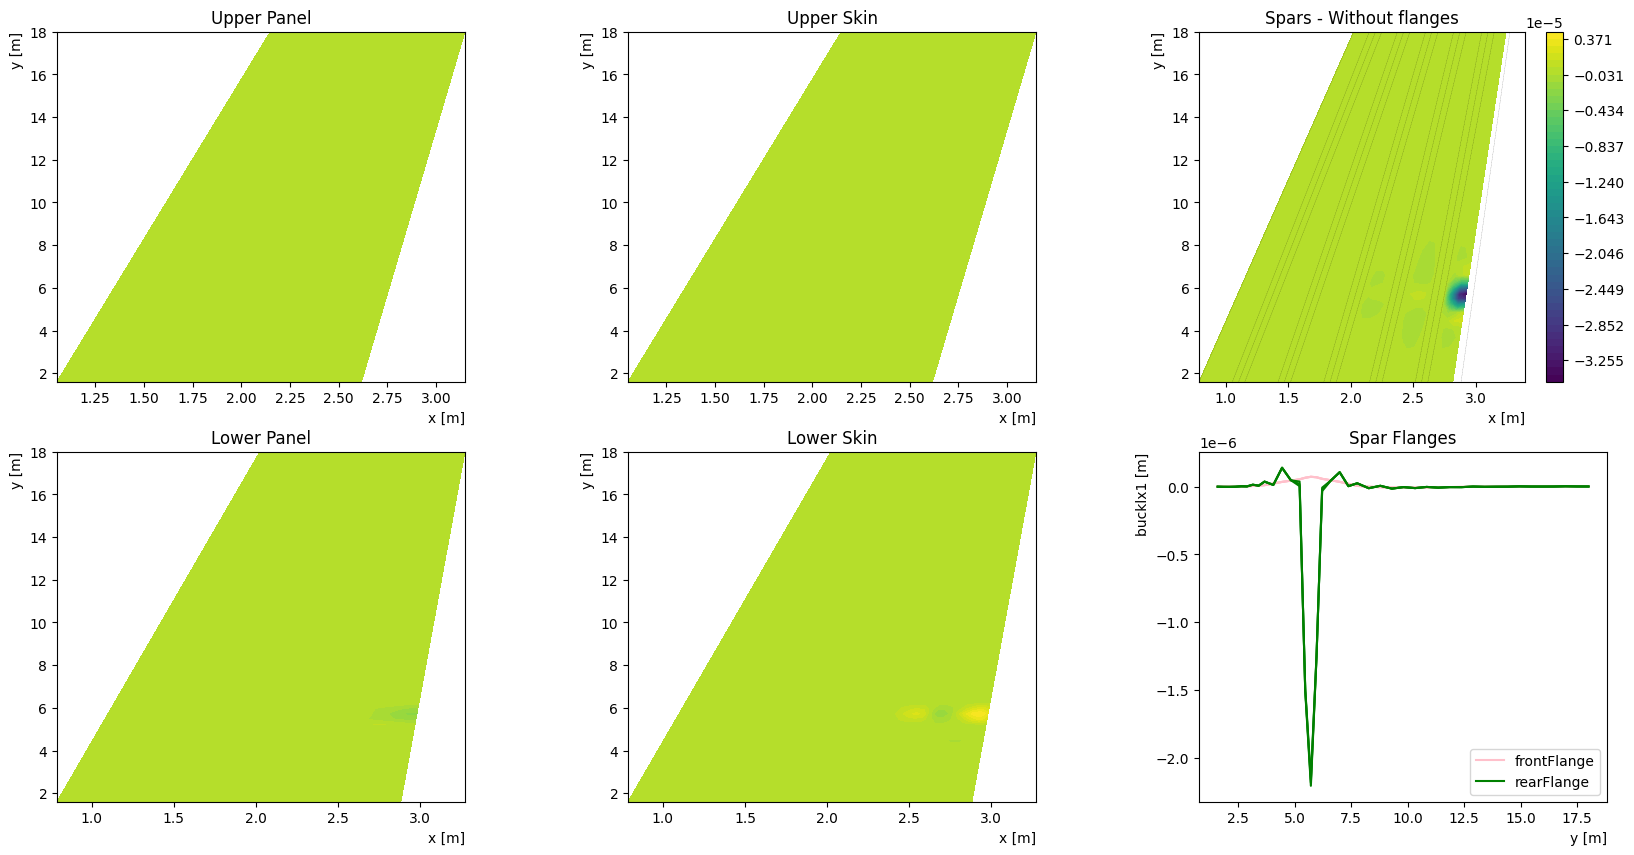

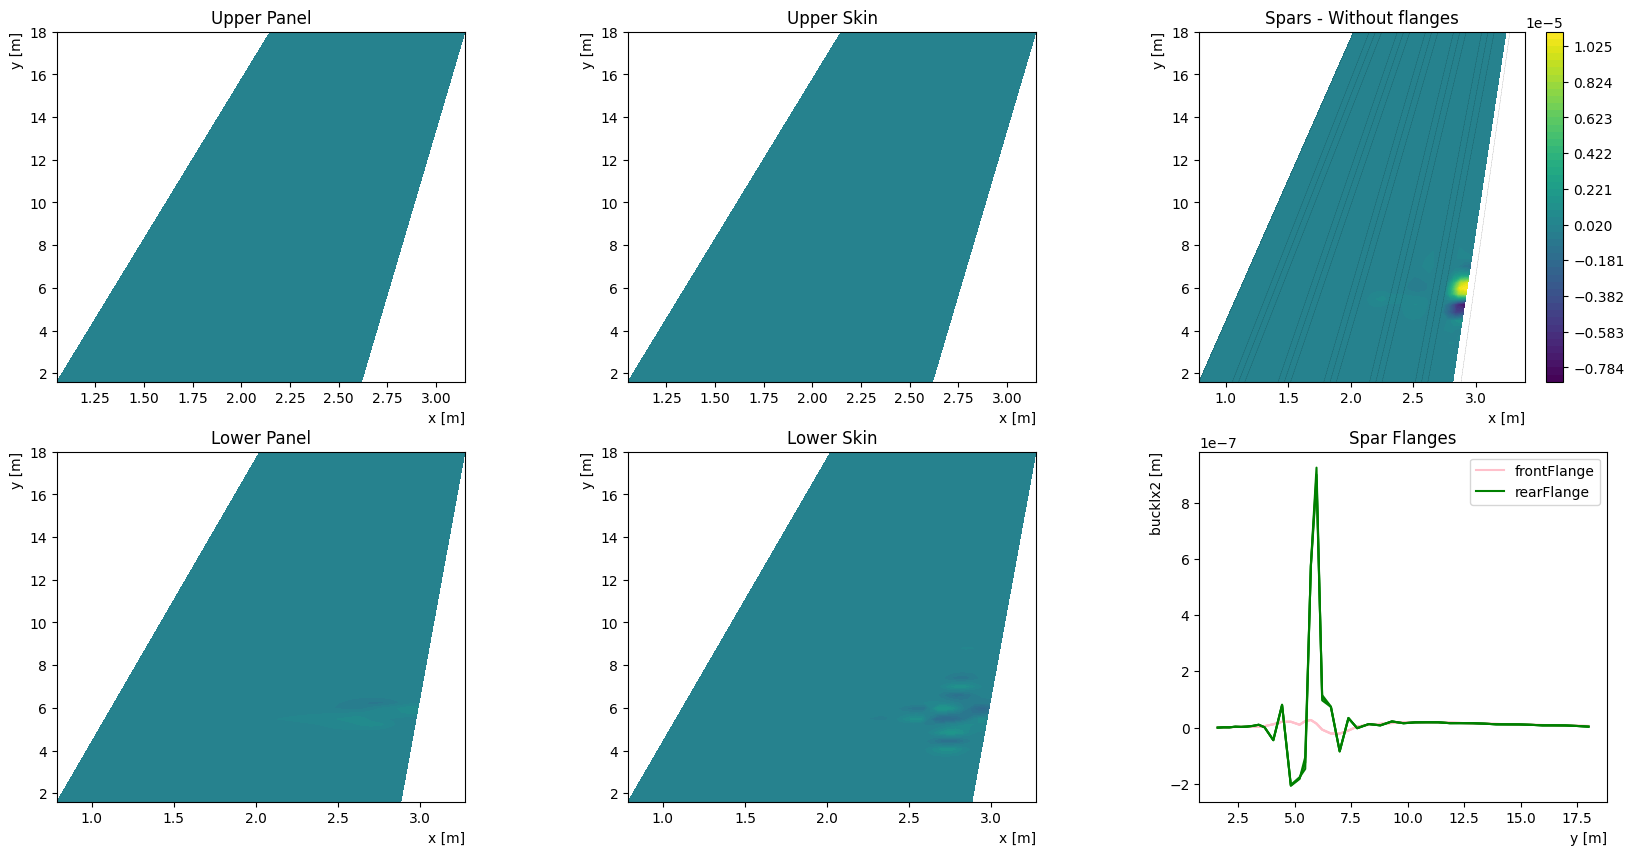

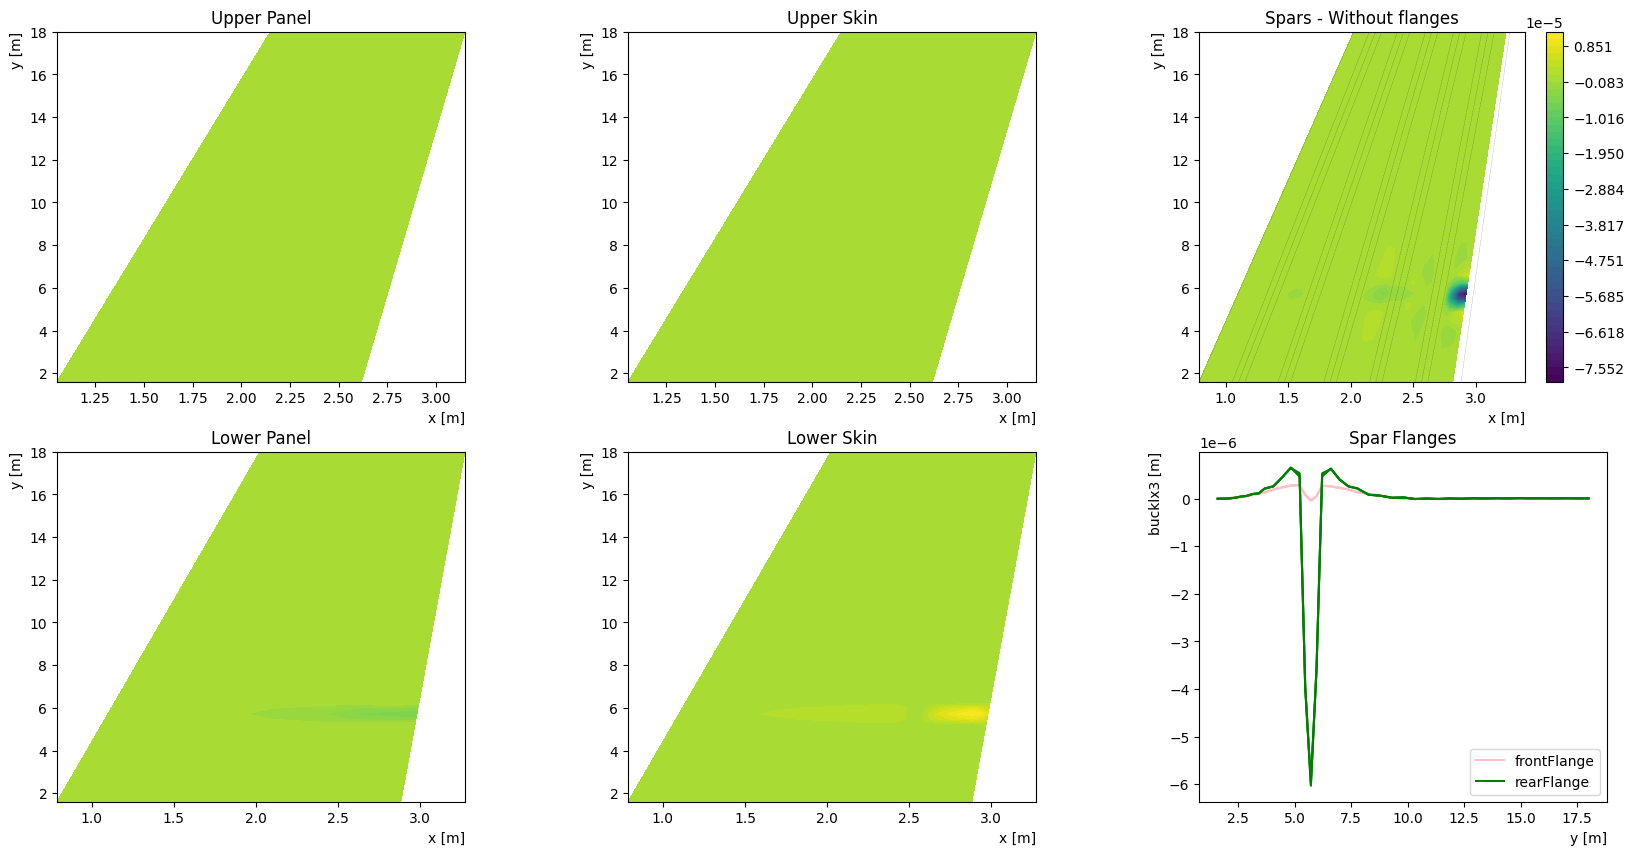

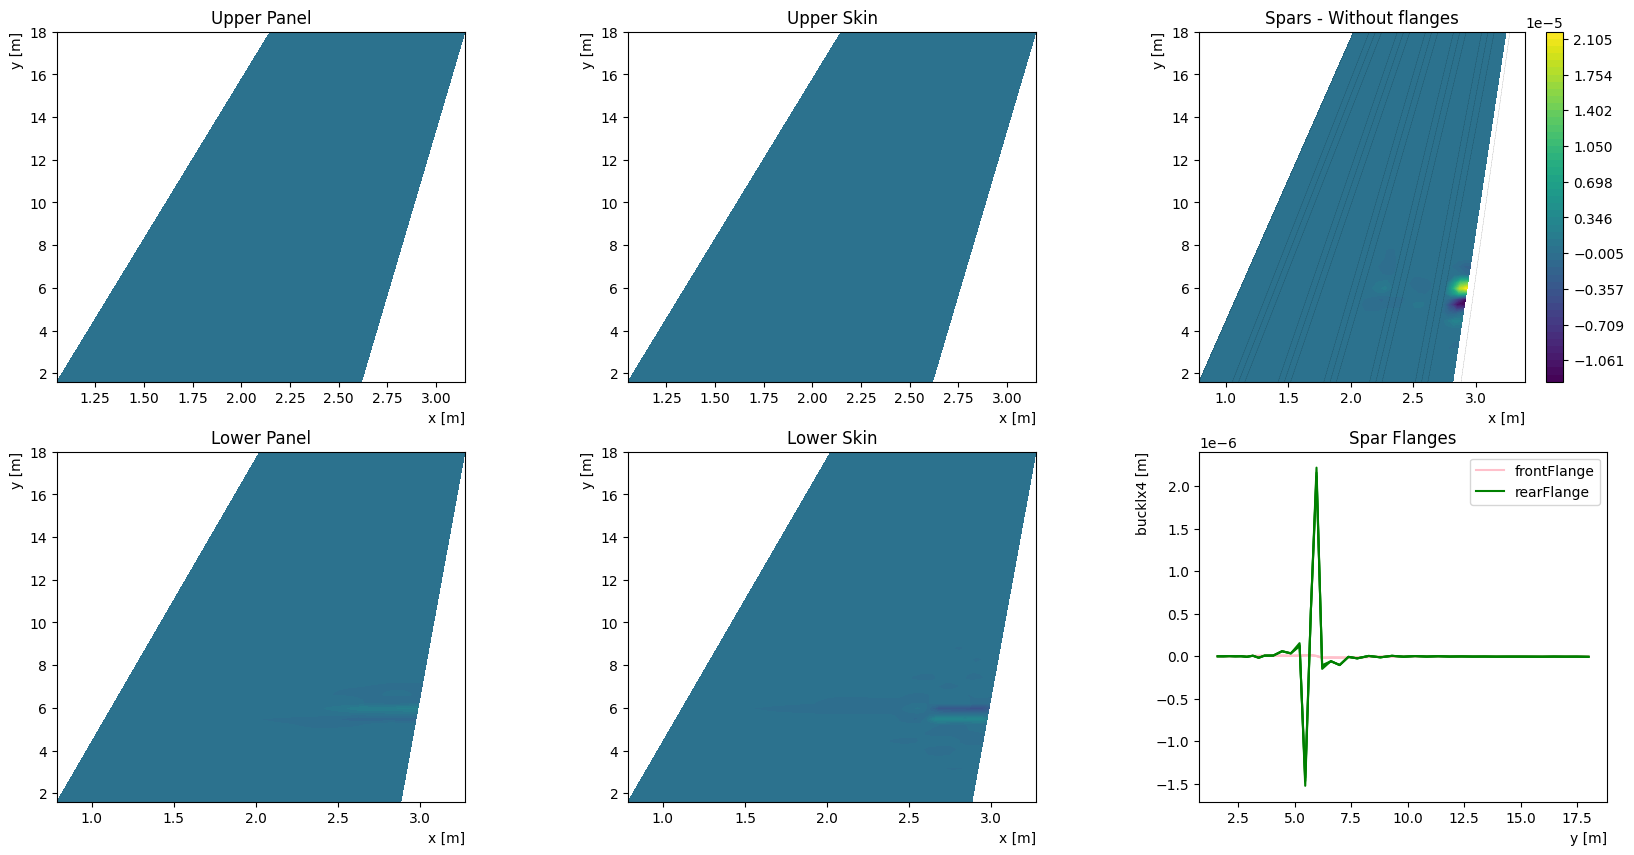

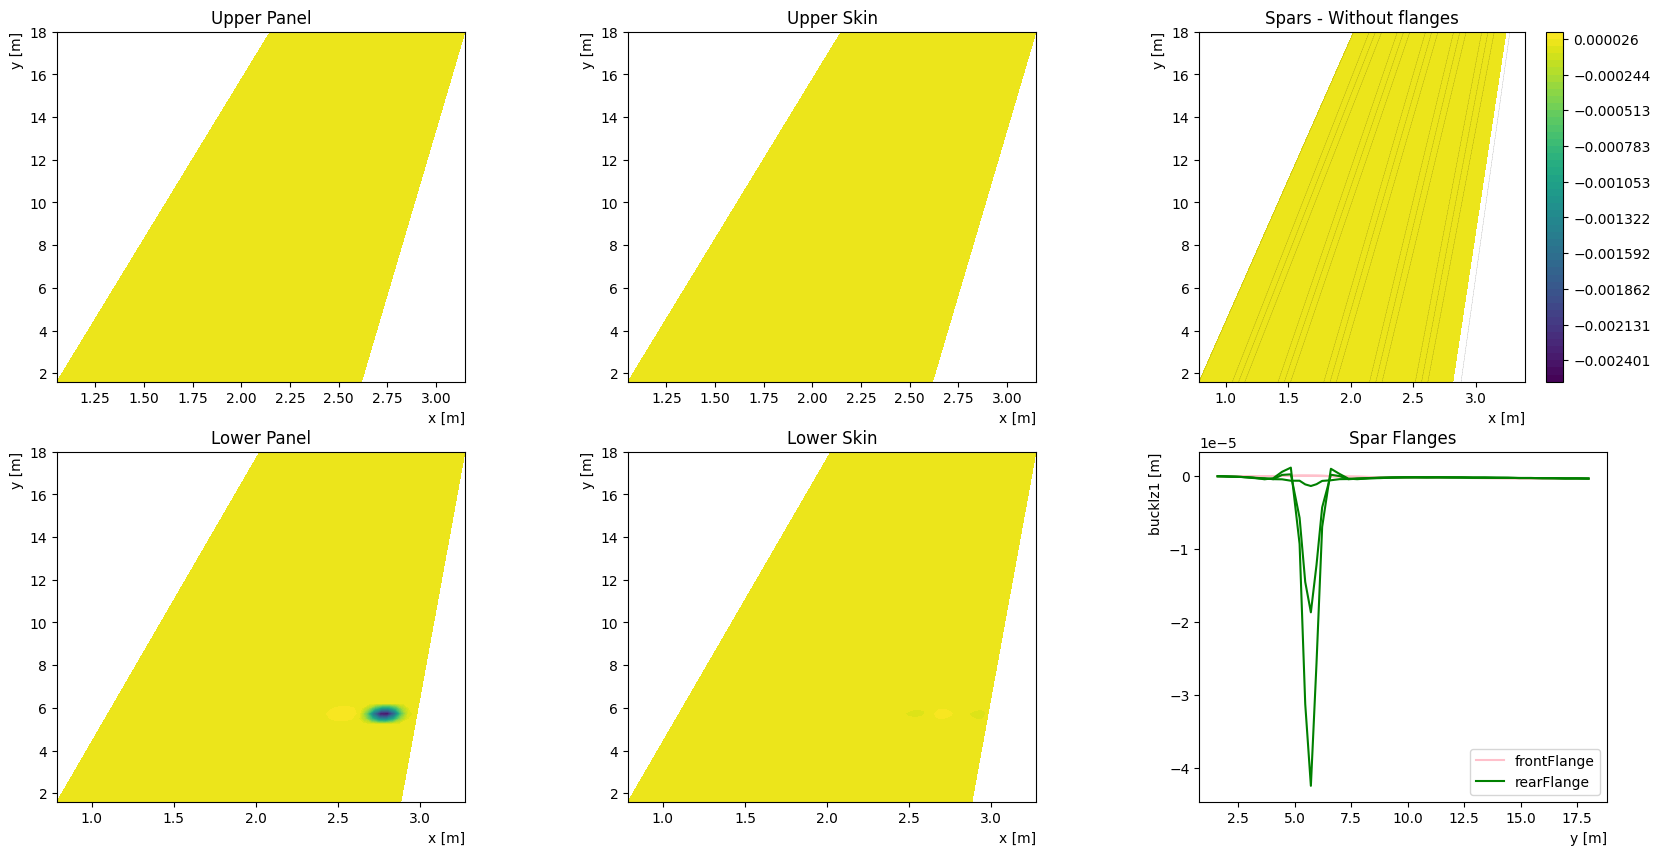

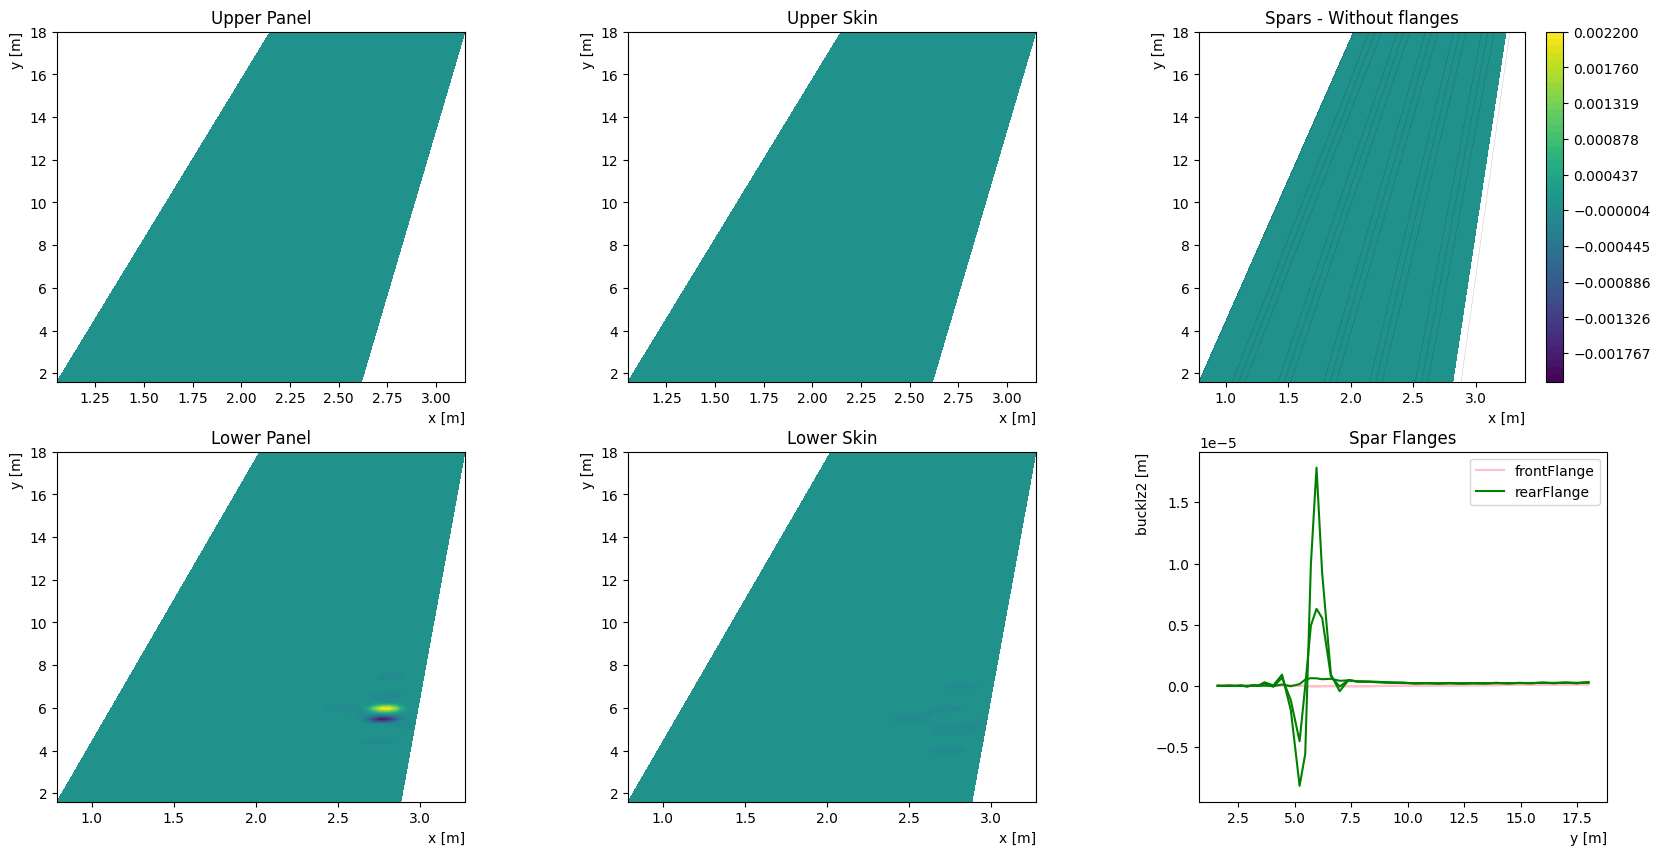

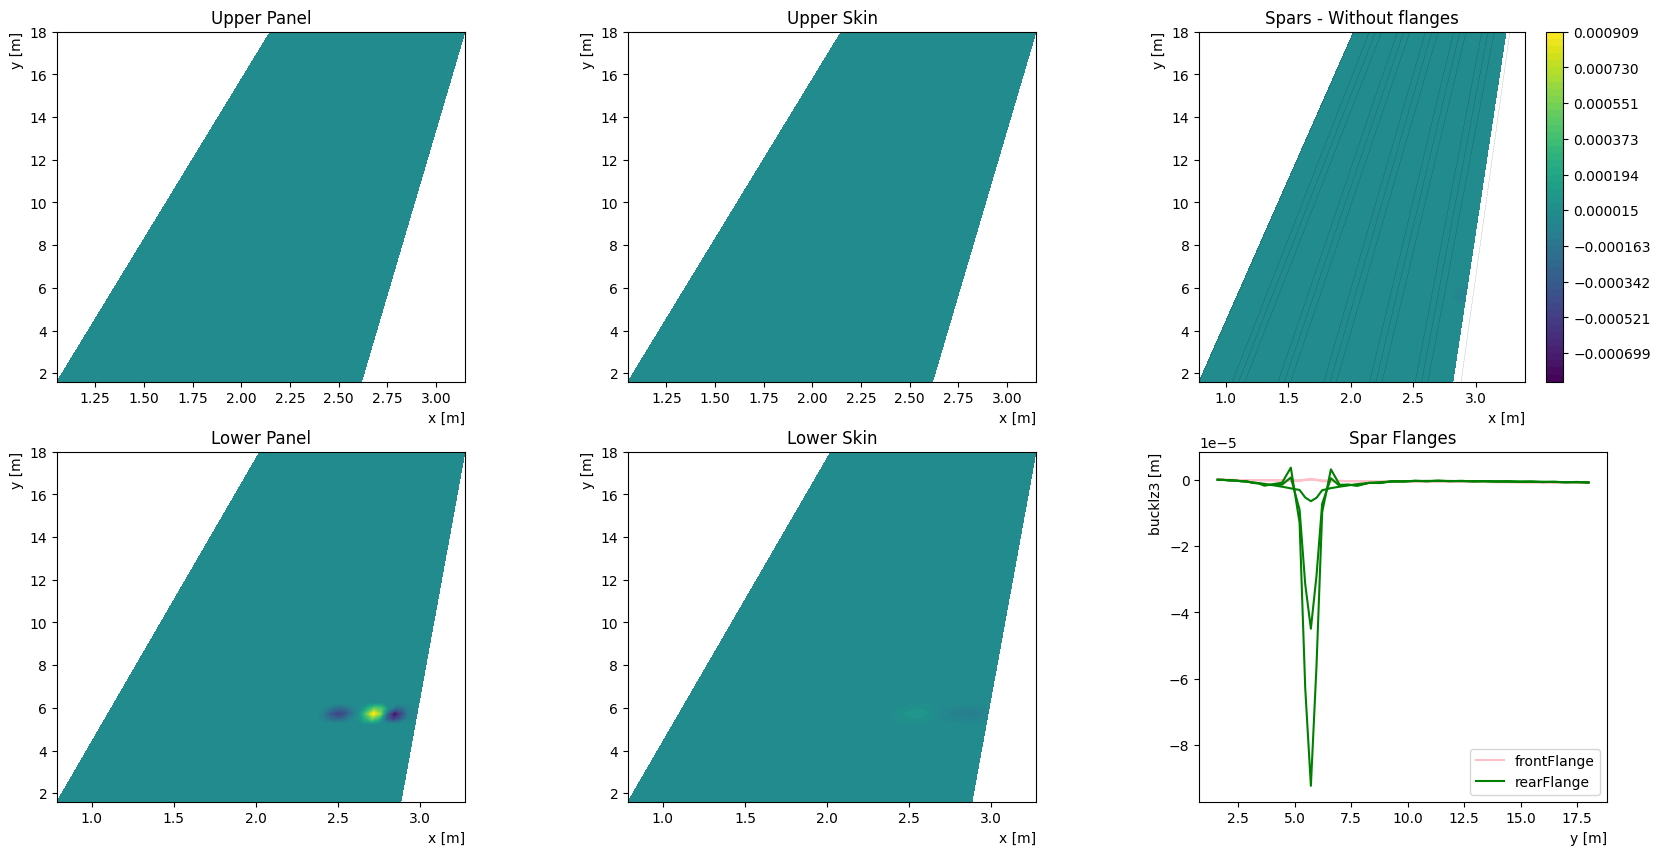

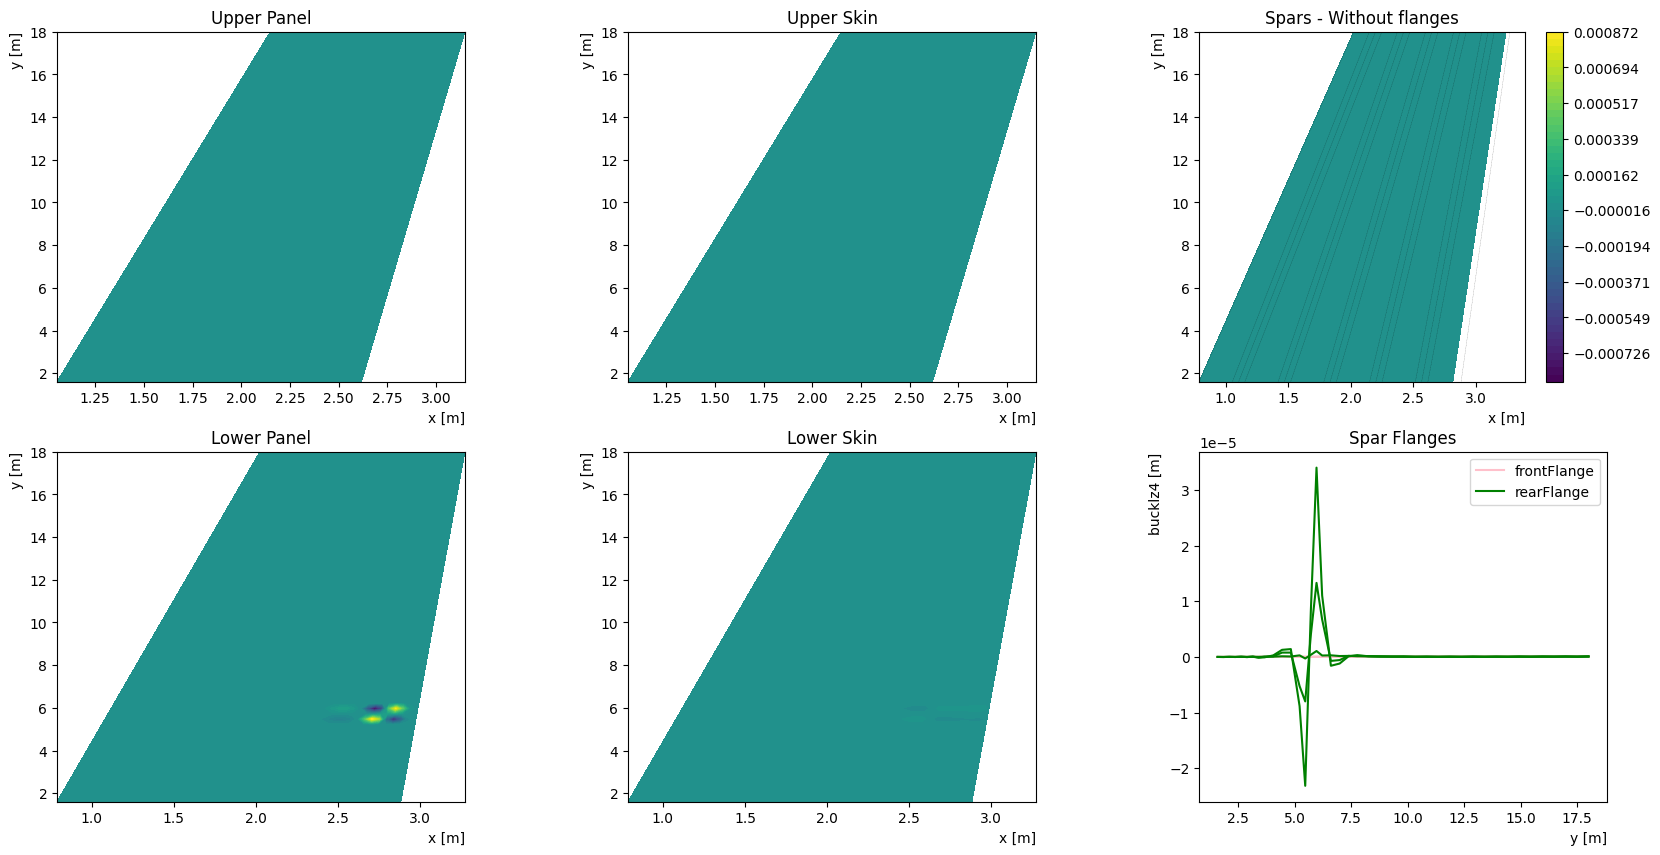

In [13]:
# bl.plot_block(ppd["fi"][0::pf3.DOF], "Fi_x", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][1::pf3.DOF], "Fi_y", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][2::pf3.DOF], "Fi_z", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][3::pf3.DOF], "Mi_x", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][4::pf3.DOF], "Mi_y", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][5::pf3.DOF], "Mi_z", meshOut, cst.CONSTS, "N")
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 0], "bucklx1", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 1], "bucklx2", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 2], "bucklx3", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 3], "bucklx4", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 0], "bucklz1", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 1], "bucklz2", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 2], "bucklz3", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 3], "bucklz4", meshOut, cst.CONSTS)
print(ppd["eigvals"])
print(ppd["load_mult"])
print(ppd["omegan"])

# Sizer

In [ ]:

'''A separate cache for eigenvectors'''
v0b = [None]*len(cst.LOAD_C)
v0f = [None]*len(cst.LOAD_C)

@ftl.cache
def _function_optim(optimVars:nt.NDArray[np.float64]):
    '''to be wrapped for particular outputs'''
    sizerVars = {
        'tspar':optimVars[0],
        'tskin':optimVars[1],
        'tpan':optimVars[2],
        'trib':optimVars[3],
        'csp':optimVars[4],
    }

    eleDict = ed.eledict(cst.CONSTS, sizerVars, cst.CODES)
    meshOut = bl.mesh_block(cst.CAD_DATA, sizerVars, eleDict, cst.CONSTS, cst.CODES)
    lfems, lppcs = list(), list()
    jmax_omegans, ldms = list(), list()
    for i, lc in enumerate(cst.LOAD_C):
        femres = bl.fem_linear_block(cst.CONSTS, meshOut, lc)
        ppcres = post_processor_block(femres, meshOut, cst.CODES, sizerVars, cst.CONSTS, v0b[i], v0f[i])
        lfems.append(femres)
        lppcs.append(ppcres)
        jmax_omegans.append(max(np.imag(ppcres["omegan"])))
        ldms.append(ppcres["load_mult"])
        v0b[i] = ppcres["v0b"]
        v0f[i] = ppcres["v0f"]
    
    #constraints
    jmax_omegan = max(jmax_omegans) #there should be no complex part of the natural frequencies, so this has to be kept at 0
    load_mul = max(ldms) #load multiplier for buckling has to be strictly greater than 1
    
    tau_margs, sigma_margs = {}, {}
    def stress_margin(code:str, eletype:str, mat:str): #maximum over all load cases
        return (max(max([ppc["sigma"][eletype][code] for ppc in lppcs]))/cst.CONSTS[f"SIGMAY_{mat}"]/cst.CONSTS["YIELD_MARGIN"], 
                max(max([ppc["tau"][eletype][code] for ppc in lppcs]))/cst.CONSTS[f"TAUY_{mat}"]/cst.CONSTS["YIELD_MARGIN"])
    sigma_margs[cst.CODES["spar"]], tau_margs[cst.CODES["spar"]] = stress_margin(cst.CODES["spar"], "quad", "ALU")
    sigma_margs[cst.CODES["skin"]], tau_margs[cst.CODES["skin"]] = stress_margin(cst.CODES["skin"], "quad", "ALU")
    sigma_margs[cst.CODES["panelPlate"]], tau_margs[cst.CODES["panelPlate"]] = stress_margin(cst.CODES["panelPlate"], "quad", "ALU")
    sigma_margs[cst.CODES["panelRib"]], tau_margs[cst.CODES["panelRib"]] = stress_margin(cst.CODES["panelRib"], "quad", "ALU")
    sigma_margs[cst.CODES["panelFlange"]], tau_margs[cst.CODES["panelFlange"]] = stress_margin(cst.CODES["panelFlange"], "beam", "ALU")
    sigma_margs[cst.CODES["rail"]], tau_margs[cst.CODES["rail"]] = stress_margin(cst.CODES["rail"], "beam", "STEEL")
    
    #objective
    totWgMass = meshOut["M"].diagonal()[2::pf3.DOF].sum()            
    
    return totWgMass, jmax_omegan, load_mul, sigma_margs, tau_margs

def mass_objective(optimVars:nt.NDArray[np.float64]):
    totWgMass, _, _, _, _ = _function_optim(tuple(optimVars))
    return totWgMass

def buckling_constraint(optimVars:nt.NDArray[np.float64]):
    _, _, load_mul, _, _ = _function_optim(tuple(optimVars))
    return load_mul

_buckling_constraint = opt.NonlinearConstraint(buckling_constraint, 0, 1)

def flutter_constraint(optimVars:nt.NDArray[np.float64]):
    _, jmax_omegan, _, _, _ = _function_optim(tuple(optimVars))
    return jmax_omegan

_flutter_constraint = opt.NonlinearConstraint(flutter_constraint, -.001, .001) #TODO determine tolerance

# Create a constraint for a specific sigma_margs index
def make_sigma_constraint(idx):
    def constraint(optimVars):
        _, _, _, sigma_margs, _ = _function_optim(optimVars)
        return np.array([sigma_margs[idx]])  # single value in array
    return opt.NonlinearConstraint(constraint, -1, 1)

# Create a constraint for a specific tau_margs index
def make_tau_constraint(idx):
    def constraint(optimVars):
        _, _, _, _, tau_margs = _function_optim(optimVars)
        return np.array([tau_margs[idx]])  # single value in array
    return opt.NonlinearConstraint(constraint, -1, 1)

# Build the lists of constraints
sigma_constraints = [make_sigma_constraint(i) for i in range(6)]
tau_constraints   = [make_tau_constraint(i) for i in range(6)]

_len_opt_Vars = len(cst.INITIAL.keys())
_ts_only_mat = np.eye(_len_opt_Vars)
_ts_only_mat[-1, -1] = 0 #removing the cs
_trange_constraint = opt.LinearConstraint(_ts_only_mat, 0, .01) #everything but cspacing

_ss_only_mat = np.zeros((_len_opt_Vars, _len_opt_Vars))
_ss_only_mat[-1, -1] = 1
_srange_constraint = opt.LinearConstraint(_ss_only_mat, 0, 1)

#an assembly of all the constraints needed
constraints = [_srange_constraint, _trange_constraint, _buckling_constraint, _flutter_constraint]+sigma_constraints+tau_constraints

# Counter and logging interval
class Logger:
    def __init__(self, every_n=10):
        self.count = 0
        self.every_n = every_n

    def __call__(self, xk):
        self.count += 1
        if self.count % self.every_n == 0:
            print(f"Iter {self.count}: x = {xk}, f = {mass_objective(xk)}, time = {datetime.datetime.now()}")


#this block is directly dependent on the cst module
def sizer_block():
    return opt.minimize(mass_objective, [cst.INITIAL[k] for k in ['tspar', 'tskin', 'tpan', 'trib', 'csp']], constraints=constraints,
                        method="COBYLA", callback=Logger())

## Main optim function testing

In [ ]:
optimVars=tuple(cst.INITIAL[k] for k in ['tspar', 'tskin', 'tpan', 'trib', 'csp'])
loadm = buckling_constraint(optimVars)
print(f"load multiplier: {loadm}")
jmax_omegan = flutter_constraint(optimVars)
print(f"complex part of natural freq: {loadm}")

C:\Users\marri\AppData\Local\Temp\ipykernel_7332\3008388835.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  eigvectsO[bu] = eigvectsOu[:, 0]


ValueError: Input must be 1- or 2-d.